# Pre Processing DMS datasets

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO 
from Bio import Seq 

pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')

In [2]:
# Load the Excel file
xls = pd.ExcelFile('data/DMS_descriptions_NIHMS1014772_sup2.xlsx')


# Get the sheet names
sheet_names = xls.sheet_names

print(f'Number of datasets in the file: ', len(sheet_names))

Number of datasets in the file:  44


In [3]:
# index finder based on xslx
def find_index(file_name):
    """
    This function finds the index of the file name from the xslx, assuming sheet_names is already loaded in.
    If file not found returns message.
    """
    for idx, name in enumerate(sheet_names):
        if name == file_name:
            return idx
        
    print("Index not found- recheck file name or spelling")

In [4]:
# functions to get mutations and create mutated seq from wt
import re

def split_string(input_string):
    """
    This function takes in the string representation of a mutation and splits it if it follows the correct pattern

    Parameters:
      - input_string (string): string representation of a single mutation. ex: "A12C"

    Returns:
      - list: returns list of elements in the form of [string, int, string]. 
          Empty if the mutation does not follow the correct pattern.
    """
    pattern = r'([A-Za-z*]+)(\d+)([A-Za-z*_]+)'
    matches = re.match(pattern, input_string)
    if matches:
        return [matches.group(1), int(matches.group(2)), matches.group(3)]
    else:
        # Return some default value, such as an empty list
        return []



def mutated_seqs(mutation, wt, offset = True):
    """
    This function takes in any mutation(s) and appies it to the wt seq given. It can handle any number of mutations,
    so long as they are separated by ":". 
    
    Parameters:
     - mutation (string): mutation information containing the wt AA, the coordinate, and the mutated AA. 
          Multiple mutations separated by a ":". ex: "A12C:W15T"
     - wt (string): the original wt sequence of the protein.
     - offset (bool): allows for the coordinate to be adjusted to python indices if defaulted to True. If false, does not. Some mutation data did not
          require the coordinate to be offset.

    Returns:
     - seq (string): returns the mutated sequence with the new mutations. If the original wt AA from mutation and the mutation coordinate
          does not match up on the wt string, then the orignal wt sequence will be returned.
    """
    if mutation.upper() == "WT":
        return wt

    # if there are multiple mutations, split on :
    mutations = mutation.split(':')
    seq = wt

    for mutation in mutations:
        mut = split_string(mutation)

        wt_AA, coor, sub = mut
        
        # coor must be one less due to nature of python indices
        if offset == True:
            coor -= 1  

        if '*' in sub and seq[coor] == wt_AA:
            seq = seq[:coor]
        elif '*' in wt_AA:
            seq += sub

        else:
            if seq[coor] == wt_AA:
                seq = seq[:coor] + sub + seq[coor + 1:]
            
            # if wt_AA from mutation does not match up with the actual AA in wt, return wt seq instead
            else:
                print("returned wt", mutation)

    return seq

In [5]:
# make a fasta file with all the mutation data
def fasta_file_maker(df, filename):
    """"
    This function takes in a dataframe and a file name in order to write a fasta file for mutation data.
    For each mutation, the first line has the ID. The second line is the mutated sequence.

    Parameters:
      - df (pandas DataFrame): dataframe containing 'ID' and 'mut_seqs' for the specific protein
      - filename (str): the name of the fasta file that will be created, without the ".fasta"

    Returns:
      - nothing.

    """
    file_path = "data/mut_sequences/" + filename + "_muts.fasta"
    dict_seq = dict(zip(df['ID'], df['mut_seqs']))

    with open(file_path, 'w') as f:
      for k, v in dict_seq.items():
        f.write(f'>{k}\n{v}\n')

# BG_STRSQ

In [114]:
# BG_STRSQ_hmmerbit
idx = find_index("BG_STRSQ_hmmerbit")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,enrichment,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,M1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,M1D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,M1E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,M1F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,M1G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10014,10014,H501S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10015,10015,H501T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10016,10016,H501V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10017,10017,H501W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
# sequence comes from dataset
# remove mutation and grab the unique values
real_wt = df['mutant'].str[:-1]
real_wt = real_wt.unique()
# convert to ints then see if the indices are correct
# by checking if they are in ascended order
wt_order = [int(s[1:]) for s in real_wt]
is_sorted = wt_order == sorted(wt_order)
range_list = list(range(1, len(real_wt)+1))
no_missing_indices = range_list == wt_order
print(is_sorted)
print(no_missing_indices)

# extracting the first letter since we know they are in order
# then joining to combine it all into one string
real_wt_seq = [s[0] for s in real_wt]
wt_seq = "".join(real_wt_seq)
wt_seq

True
True


'MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSIWDTYARTPGRVRNGDTGDVATDHYHRWREDVALMAELGLGAYRFSLAWPRIQPTGRGPALQKGLDFYRRLADELLAKGIQPVATLYHWDLPQELENAGGWPERATAERFAEYAAIAADALGDRVKTWTTLNEPWCSAFLGYGSGVHAPGRTDPVAALRAAHHLNLGHGLAVQALRDRLPADAQCSVTLNIHHVRPLTDSDADADAVRRIDALANRVFTGPMLQGAYPEDLVKDTAGLTDWSFVRDGDLRLAHQKLDFLGVNYYSPTLVSEADGSGTHNSDGHGRSAHSPWPGADRVAFHQPPGETTAMGWAVDPSGLYELLRRLSSDFPALPLVITENGAAFHDYADPEGNVNDPERIAYVRDHLAAVHRAIKDGSDVRGYFLWSLLDNFEWAHGYSKRFGAVYVDYPTGTRIPKASARWYAEVARTGVLPTAGDPNSSSVDKLAAALEHHHHHH'

In [116]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,enrichment,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,M1C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
1,1,M1D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
2,2,M1E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
3,3,M1F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
4,4,M1G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
...,...,...,...,...,...,...,...,...,...,...,...,...
10014,10014,H501S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
10015,10015,H501T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
10016,10016,H501V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
10017,10017,H501W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...


In [9]:
df['ID'] = 'BG_STRSQ_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'enrichment', 'mut_seqs']
df = df[cols]

df = df.dropna(subset=['enrichment']).copy()
df

,ID,mutant,enrichment,mut_seqs
9,BG_STRSQ_M1M,M1M,0.000,MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
19,BG_STRSQ_V2A,V2A,-0.162,MAPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
21,BG_STRSQ_V2D,V2D,0.227,MDPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
23,BG_STRSQ_V2F,V2F,0.341,MFPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
24,BG_STRSQ_V2G,V2G,-0.241,MGPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
...,...,...,...,...
10010,BG_STRSQ_H501N,H501N,-0.456,MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
10011,BG_STRSQ_H501P,H501P,-0.613,MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
10012,BG_STRSQ_H501Q,H501Q,-0.310,MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...
10013,BG_STRSQ_H501R,H501R,-0.199,MVPAAQQTAMAPDAALTFPEGFLWGSATASYQIEGAAAEDGRTPSI...


In [10]:
# make fasta
fasta_file_maker(df, 'BG_STRSQ_hmmerbit')

In [11]:
# make metadata
df.rename(columns={'enrichment': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/BG_STRSQ_hmmerbit_metadata.csv')

# BLAT_ECOLX_Ostermeier2014

In [12]:
# BLAT_ECOLX_Ostermeier2014
idx = find_index("BLAT_ECOLX_Ostermeier2014")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,linear,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,M1C,0.0030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,M1E,0.0024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,M1D,0.0022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,M1G,0.0012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,M1F,0.0057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5463,5463,W286S,0.0045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5464,5464,W286R,0.0129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5465,5465,W286T,0.0037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5466,5466,W286V,0.0057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# P62593.fasta
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P62593.fasta', 'fasta').seq)
wt_seq

'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW'

In [14]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,linear,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,M1C,0.0030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
1,1,M1E,0.0024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
2,2,M1D,0.0022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
3,3,M1G,0.0012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
4,4,M1F,0.0057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
...,...,...,...,...,...,...,...,...,...,...,...,...
5463,5463,W286S,0.0045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
5464,5464,W286R,0.0129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
5465,5465,W286T,0.0037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
5466,5466,W286V,0.0057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...


In [15]:
df['ID'] = 'BLAT_Ost_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'linear', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['linear']).copy()
df.head()

,ID,mutant,linear,mut_seqs
0,BLAT_Ost_M1C,M1C,0.0030,CSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
1,BLAT_Ost_M1E,M1E,0.0024,ESIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
2,BLAT_Ost_M1D,M1D,0.0022,DSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
3,BLAT_Ost_M1G,M1G,0.0012,GSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
4,BLAT_Ost_M1F,M1F,0.0057,FSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...


In [16]:
# make fasta
fasta_file_maker(df, 'BLAT_ECOLX_Ostermeier2014')

In [17]:
df.rename(columns={'linear': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/BLAT_ECOLX_Ostermeier2014_metadata.csv')

# BLAT_ECOLX_Ranganathan2015

In [18]:
# BLAT_ECOLX_Ranganathan2015
idx = find_index("BLAT_ECOLX_Ranganathan2015")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,0,39,156,625,2500,cefotaxime,0_1,0_2,10_1,39_1,39_2,156_1,156_2,625_1,625_2,2500_1,2500_2,km,vmax,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,H24C,0.022702,0.045890,-0.025738,0.018871,-0.418260,-0.031941,-0.037095,0.082499,0.002591,-0.042346,0.134127,-0.010197,-0.041280,-0.014684,0.052427,-0.319357,-0.517163,0.785765,1.519964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,H24E,0.011387,-0.012636,-0.018955,-0.020436,-0.279024,0.016456,0.013497,0.009277,0.054104,-0.019678,-0.005594,0.001571,-0.039480,-0.034798,-0.006074,-0.200042,-0.358006,0.757583,1.502589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,H24D,0.042301,0.017005,0.018951,0.006743,-0.181607,-0.030326,0.033849,0.050753,0.002764,-0.007401,0.041412,0.017490,0.020413,-0.026086,0.039572,-0.155938,-0.207275,0.763290,1.622028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,H24G,0.011460,-0.024511,-0.023807,-0.017209,-0.060242,-0.009657,-0.000472,0.023393,-0.013742,-0.040919,-0.008104,-0.021926,-0.025688,-0.028225,-0.006194,-0.043527,-0.076956,1.099628,1.736941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,H24F,0.020599,0.020321,-0.015905,0.016190,-0.818487,-0.000809,0.021397,0.019801,-0.001591,-0.045411,0.086053,-0.013453,-0.018357,-0.008856,0.041237,-0.493982,-1.142992,1.074944,1.574923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,4991,W286S,-0.035006,-0.110907,-1.368384,-2.347502,-2.967712,0.049699,0.003713,-0.073724,-0.061769,-0.024788,-0.197025,-1.037579,-1.699189,-2.405871,-2.289134,-2.463131,-3.472294,0.891281,0.140269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4992,4992,W286R,-0.025877,-0.012935,-0.853984,-1.902061,-2.707731,0.021912,0.006037,-0.057790,-0.080176,-0.039498,0.013629,-0.366960,-1.341008,-1.801386,-2.002735,-2.381525,-3.033937,1.498384,0.760712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4993,4993,W286T,-0.072449,-0.120705,-1.316637,-2.070245,-2.806422,0.046944,-0.006306,-0.138592,-0.074702,-0.012398,-0.229012,-1.022829,-1.610445,-1.929036,-2.211455,-2.380080,-3.232764,3.111094,1.695994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4994,4994,W286V,-0.015917,-0.036848,-0.943011,-1.866516,-2.813837,0.027214,0.029899,-0.061734,-0.038513,-0.039365,-0.034330,-0.524840,-1.361181,-1.817991,-1.915041,-2.535303,-3.092371,1.762023,0.824707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# P62593.fasta
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P62593.fasta', 'fasta').seq)
wt_seq

'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRIDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPVAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW'

In [20]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,0,39,156,625,2500,cefotaxime,0_1,0_2,10_1,39_1,39_2,156_1,156_2,625_1,625_2,2500_1,2500_2,km,vmax,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,H24C,0.022702,0.045890,-0.025738,0.018871,-0.418260,-0.031941,-0.037095,0.082499,0.002591,-0.042346,0.134127,-0.010197,-0.041280,-0.014684,0.052427,-0.319357,-0.517163,0.785765,1.519964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFACPETLVKVKDAEDQLGARVGYIE...
1,1,H24E,0.011387,-0.012636,-0.018955,-0.020436,-0.279024,0.016456,0.013497,0.009277,0.054104,-0.019678,-0.005594,0.001571,-0.039480,-0.034798,-0.006074,-0.200042,-0.358006,0.757583,1.502589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAEPETLVKVKDAEDQLGARVGYIE...
2,2,H24D,0.042301,0.017005,0.018951,0.006743,-0.181607,-0.030326,0.033849,0.050753,0.002764,-0.007401,0.041412,0.017490,0.020413,-0.026086,0.039572,-0.155938,-0.207275,0.763290,1.622028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFADPETLVKVKDAEDQLGARVGYIE...
3,3,H24G,0.011460,-0.024511,-0.023807,-0.017209,-0.060242,-0.009657,-0.000472,0.023393,-0.013742,-0.040919,-0.008104,-0.021926,-0.025688,-0.028225,-0.006194,-0.043527,-0.076956,1.099628,1.736941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAGPETLVKVKDAEDQLGARVGYIE...
4,4,H24F,0.020599,0.020321,-0.015905,0.016190,-0.818487,-0.000809,0.021397,0.019801,-0.001591,-0.045411,0.086053,-0.013453,-0.018357,-0.008856,0.041237,-0.493982,-1.142992,1.074944,1.574923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAFPETLVKVKDAEDQLGARVGYIE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,4991,W286S,-0.035006,-0.110907,-1.368384,-2.347502,-2.967712,0.049699,0.003713,-0.073724,-0.061769,-0.024788,-0.197025,-1.037579,-1.699189,-2.405871,-2.289134,-2.463131,-3.472294,0.891281,0.140269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
4992,4992,W286R,-0.025877,-0.012935,-0.853984,-1.902061,-2.707731,0.021912,0.006037,-0.057790,-0.080176,-0.039498,0.013629,-0.366960,-1.341008,-1.801386,-2.002735,-2.381525,-3.033937,1.498384,0.760712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
4993,4993,W286T,-0.072449,-0.120705,-1.316637,-2.070245,-2.806422,0.046944,-0.006306,-0.138592,-0.074702,-0.012398,-0.229012,-1.022829,-1.610445,-1.929036,-2.211455,-2.380080,-3.232764,3.111094,1.695994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
4994,4994,W286V,-0.015917,-0.036848,-0.943011,-1.866516,-2.813837,0.027214,0.029899,-0.061734,-0.038513,-0.039365,-0.034330,-0.524840,-1.361181,-1.817991,-1.915041,-2.535303,-3.092371,1.762023,0.824707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...


In [21]:
df['ID'] = 'BLAT_Ran_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', '2500', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['2500']).copy()
df.head()

,ID,mutant,2500,mut_seqs
0,BLAT_Ran_H24C,H24C,-0.418260,MSIQHFRVALIPFFAAFCLPVFACPETLVKVKDAEDQLGARVGYIE...
1,BLAT_Ran_H24E,H24E,-0.279024,MSIQHFRVALIPFFAAFCLPVFAEPETLVKVKDAEDQLGARVGYIE...
2,BLAT_Ran_H24D,H24D,-0.181607,MSIQHFRVALIPFFAAFCLPVFADPETLVKVKDAEDQLGARVGYIE...
3,BLAT_Ran_H24G,H24G,-0.060242,MSIQHFRVALIPFFAAFCLPVFAGPETLVKVKDAEDQLGARVGYIE...
4,BLAT_Ran_H24F,H24F,-0.818487,MSIQHFRVALIPFFAAFCLPVFAFPETLVKVKDAEDQLGARVGYIE...


In [22]:
# make fasta
fasta_file_maker(df, 'BLAT_ECOLX_Ranganathan2015')

In [23]:
df.rename(columns={'2500': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/BLAT_ECOLX_Ranganathan2015_metadata.csv')

# BLAT_ECOLX_Tenaillon2013

In [24]:
# BLAT_ECOLX_Tenaillon2013
idx = find_index("BLAT_ECOLX_Tenaillon2013")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,MIC_score,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,H24P,-3.321928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,H24R,-0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,H24Y,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,H24L,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,P25Q,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1015,1015,H285L,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1016,1016,H285N,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1017,1017,W286C,-5.321928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1018,1018,W286R,-5.250499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# P62593.fasta
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P62593.fasta', 'fasta').seq)
wt_seq

'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRIDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPVAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW'

In [26]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,MIC_score,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,H24P,-3.321928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAPPETLVKVKDAEDQLGARVGYIE...
1,1,H24R,-0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFARPETLVKVKDAEDQLGARVGYIE...
2,2,H24Y,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAYPETLVKVKDAEDQLGARVGYIE...
3,3,H24L,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFALPETLVKVKDAEDQLGARVGYIE...
4,4,P25Q,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHQETLVKVKDAEDQLGARVGYIE...
...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1015,H285L,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
1016,1016,H285N,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
1017,1017,W286C,-5.321928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
1018,1018,W286R,-5.250499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...


In [27]:
df['ID'] = 'BLAT_Ten_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'MIC_score', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['MIC_score']).copy()
df.head()

,ID,mutant,MIC_score,mut_seqs
0,BLAT_Ten_H24P,H24P,-3.321928,MSIQHFRVALIPFFAAFCLPVFAPPETLVKVKDAEDQLGARVGYIE...
1,BLAT_Ten_H24R,H24R,-0.250000,MSIQHFRVALIPFFAAFCLPVFARPETLVKVKDAEDQLGARVGYIE...
2,BLAT_Ten_H24Y,H24Y,-1.000000,MSIQHFRVALIPFFAAFCLPVFAYPETLVKVKDAEDQLGARVGYIE...
3,BLAT_Ten_H24L,H24L,-0.500000,MSIQHFRVALIPFFAAFCLPVFALPETLVKVKDAEDQLGARVGYIE...
4,BLAT_Ten_P25Q,P25Q,0.000000,MSIQHFRVALIPFFAAFCLPVFAHQETLVKVKDAEDQLGARVGYIE...


In [28]:
# make fasta
fasta_file_maker(df, 'BLAT_ECOLX_Tenaillon2013')

In [29]:
df.rename(columns={'MIC_score': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/BLAT_ECOLX_Tenaillon2013_metadata.csv')

# BLAT_ECOLX_Palzkill2012

In [30]:
# BLAT_ECOLX_Palzkill2012
idx = find_index("BLAT_ECOLX_Palzkill2012")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,ddG_stat,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,H24C,3.924478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,H24E,1.486533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,H24D,2.788294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,H24G,2.113703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,H24F,4.345218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5254,5254,W286R,5.209187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5255,5255,W286T,4.963070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5256,5256,W286W,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5257,5257,W286V,4.963070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# P62593.fasta
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P62593.fasta', 'fasta').seq)
wt_seq

'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRIDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPVAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW'

In [32]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,ddG_stat,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,H24C,3.924478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFACPETLVKVKDAEDQLGARVGYIE...
1,1,H24E,1.486533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAEPETLVKVKDAEDQLGARVGYIE...
2,2,H24D,2.788294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFADPETLVKVKDAEDQLGARVGYIE...
3,3,H24G,2.113703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAGPETLVKVKDAEDQLGARVGYIE...
4,4,H24F,4.345218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAFPETLVKVKDAEDQLGARVGYIE...
...,...,...,...,...,...,...,...,...,...,...,...,...
5254,5254,W286R,5.209187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
5255,5255,W286T,4.963070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
5256,5256,W286W,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...
5257,5257,W286V,4.963070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...


In [33]:
df['ID'] = 'BLAT_Pal_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'ddG_stat', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['ddG_stat']).copy()
df.head()

,ID,mutant,ddG_stat,mut_seqs
0,BLAT_Pal_H24C,H24C,3.924478,MSIQHFRVALIPFFAAFCLPVFACPETLVKVKDAEDQLGARVGYIE...
1,BLAT_Pal_H24E,H24E,1.486533,MSIQHFRVALIPFFAAFCLPVFAEPETLVKVKDAEDQLGARVGYIE...
2,BLAT_Pal_H24D,H24D,2.788294,MSIQHFRVALIPFFAAFCLPVFADPETLVKVKDAEDQLGARVGYIE...
3,BLAT_Pal_H24G,H24G,2.113703,MSIQHFRVALIPFFAAFCLPVFAGPETLVKVKDAEDQLGARVGYIE...
4,BLAT_Pal_H24F,H24F,4.345218,MSIQHFRVALIPFFAAFCLPVFAFPETLVKVKDAEDQLGARVGYIE...


In [34]:
# make fasta
fasta_file_maker(df, 'BLAT_ECOLX_Palzkill2012')

In [35]:
df.rename(columns={'ddG_stat': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/BLAT_ECOLX_Palzkill2012_metadata.csv')

# DLG

In [36]:
# DLG4_RAT_Ranganathan2012
idx = find_index("DLG4_RAT_Ranganathan2012")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,CRIPT,Tm2F,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,P311C,0.165650,-0.106820,-5.038374,-6.246232,-4.265556,-4.616559,-5.391722,-4.671803,-5.922571,-2.566077
1,1,P311E,0.116640,-0.238050,-2.656604,-4.318409,-1.096447,-2.260294,-3.886608,-1.721265,-4.315602,-0.978928
2,2,P311D,0.229710,-0.034348,-6.065952,-6.871219,-4.833020,-6.142723,-7.160925,-5.321874,-7.558077,-4.379107
3,3,P311G,0.289660,-0.170190,-7.037070,-7.992291,-5.991476,-6.875580,-6.570930,-7.755071,-8.474353,-5.268378
4,4,P311F,0.268900,-0.175060,-5.429961,-7.576856,-4.165015,-4.584117,-6.168788,-4.655028,-5.833194,-1.826012
...,...,...,...,...,...,...,...,...,...,...,...,...
1654,1654,K393R,0.004051,-0.123410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1655,1655,K393T,0.002765,-0.097417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1656,1656,K393W,-0.020886,-0.161800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1657,1657,K393V,-0.070006,0.005044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# P31016.fasta
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P31016.fasta', 'fasta').seq)
wt_seq

'MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLEAPGYELQVNGTEGEMEYEEITLERGNSGLGFSIAGGTDNPHIGDDPSIFITKIIPGGAAAQDGRLRVNDSILFVNEVDVREVTHSAAVEALKEAGSIVRLYVMRRKPPAEKVMEIKLIKGPKGLGFSIAGGVGNQHIPGDNSIYVTKIIEGGAAHKDGRLQIGDKILAVNSVGLEDVMHEDAVAALKNTYDVVYLKVAKPSNAYLSDSYAPPDITTSYSQHLDNEISHSSYLGTDYPTAMTPTSPRRYSPVAKDLLGEEDIPREPRRIVIHRGSTGLGFNIVGGEDGEGIFISFILAGGPADLSGELRKGDQILSVNGVDLRNASHEQAAIALKNAGQTVTIIAQYKPEEYSRFEAKIHDLREQLMNSSLGSGTASLRSNPKRGFYIRALFDYDKTKDCGFLSQALSFRFGDVLHVIDAGDEEWWQARRVHSDSETDDIGFIPSKRRVERREWSRLKAKDWGSSSGSQGREDSVLSYETVTQMEVHYARPIIILGPTKDRANDDLLSEFPDKFGSCVPHTTRPKREYEIDGRDYHFVSSREKMEKDIQAHKFIEAGQYNSHLYGTSVQSVREVAEQGKHCILDVSANAVRRLQAAHLHPIAIFIRPRSLENVLEINKRITEEQARKAFDRATKLEQEFTECFSAIVEGDSFEEIYHKVKRVIEDLSGPYIWVPARERL'

In [38]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,CRIPT,Tm2F,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,P311C,0.165650,-0.106820,-5.038374,-6.246232,-4.265556,-4.616559,-5.391722,-4.671803,-5.922571,-2.566077,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...
1,1,P311E,0.116640,-0.238050,-2.656604,-4.318409,-1.096447,-2.260294,-3.886608,-1.721265,-4.315602,-0.978928,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...
2,2,P311D,0.229710,-0.034348,-6.065952,-6.871219,-4.833020,-6.142723,-7.160925,-5.321874,-7.558077,-4.379107,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...
3,3,P311G,0.289660,-0.170190,-7.037070,-7.992291,-5.991476,-6.875580,-6.570930,-7.755071,-8.474353,-5.268378,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...
4,4,P311F,0.268900,-0.175060,-5.429961,-7.576856,-4.165015,-4.584117,-6.168788,-4.655028,-5.833194,-1.826012,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,1654,K393R,0.004051,-0.123410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...
1655,1655,K393T,0.002765,-0.097417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...
1656,1656,K393W,-0.020886,-0.161800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...
1657,1657,K393V,-0.070006,0.005044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...


In [39]:
df['ID'] = 'DLG4_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'CRIPT', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['CRIPT']).copy()
df.head()

,ID,mutant,CRIPT,mut_seqs
0,DLG4_P311C,P311C,0.16565,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...
1,DLG4_P311E,P311E,0.11664,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...
2,DLG4_P311D,P311D,0.22971,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...
3,DLG4_P311G,P311G,0.28966,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...
4,DLG4_P311F,P311F,0.26890,MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLE...


In [40]:
# make fasta
fasta_file_maker(df, 'DLG4_RAT_Ranganathan2012')

In [41]:
df.rename(columns={'CRIPT': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/DLG4_RAT_Ranganathan2012_metadata.csv')

# GAL4

In [42]:
# GAL4_YEAST_Shendure2015
idx = find_index("GAL4_YEAST_Shendure2015")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,NONSEL_24h,SEL_A_24h,SEL_A_40h,SEL_B_40h,SEL_C_40h,SEL_C_64h,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,K2C,0.84,0.75,1.04,0.77,0.44,2.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,K2E,1.10,-4.89,-7.14,-9.99,-10.26,-12.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,K2D,1.24,-1.57,-1.53,-4.95,-4.40,-2.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,K2G,1.32,1.72,1.77,1.18,1.84,2.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,K2F,1.24,0.12,0.15,0.16,-0.11,1.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,1190,E65R,0.34,-2.67,-2.25,-3.87,-3.22,-1.75,-3.729180,-3.535471,-3.360132,-3.421583,-4.328350,-4.000362,-3.848318,-3.050464
1191,1191,E65T,0.72,0.35,0.43,0.58,0.46,0.46,-3.965621,-3.497327,-4.145123,-3.521198,-4.887167,-3.777291,-3.277695,-3.213183
1192,1192,E65W,0.93,-2.21,-1.69,-5.78,-5.24,-4.97,-7.220323,-7.042665,-6.690415,-6.908104,-7.933000,-7.527431,-7.322675,-6.650309
1193,1193,E65V,1.00,-1.02,-0.97,-1.62,-1.95,-0.43,-5.450923,-5.117962,-5.461238,-5.351004,-6.004376,-5.320038,-5.966879,-4.420540


In [ ]:
# P04386.fasta.txt
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P04386.fasta', 'fasta').seq)
wt_seq

'MKLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKRSPLTRAHLTEVESRLERLEQLFLLIFPREDLDMILKMDSLQDIKALLTGLFVQDNVNKDAVTDRLASVETDMPLTLRQHRISATSSSEESSNKGQRQLTVSIDSAAHHDNSTIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPNNNGFFGDGSLLCILRSIGFKPENYTNSNVNRLPTMITDRYTLASRSTTSRLLQSYLNNFHPYCPIVHSPTLMMLYNNQIEIASKDQWQILFNCILAIGAWCIEGESTDIDVFYYQNAKSHLTSKVFESGSIILVTALHLLSRYTQWRQKTNTSYNFHSFSIRMAISLGLNRDLPSSFSDSSILEQRRRIWWSVYSWEIQLSLLYGRSIQLSQNTISFPSSVDDVQRTTTGPTIYHGIIETARLLQVFTKIYELDKTVTAEKSPICAKKCLMICNEIEEVSRQAPKFLQMDISTTALTNLLKEHPWLSFTRFELKWKQLSLIIYVLRDFFTNFTQKKSQLEQDQNDHQSYEVKRCSIMLSDAAQRTVMSVSSYMDNHNVTPYFAWNCSYYLFNAVLVPIKTLLSNSKSNAENNETAQLLQQINTVLMLLKKLATFKIQTCEKYIQVLEEVCAPFLLSQCAIPLPHISYNNSNGSAIKNIVGSATIAQYPTLPEENVNNISVKYVSPGSVGPSPVPLKSGASFSDLVKLLSNRPPSRNSPVTIPRSTPSHRSVTPFLGQQQQLQSLVPLTPSALFGGANFNQSGNIADSSLSFTFTNSSNGPNLITTQTNSQALSQPIASSNVHDNFMNNEITASKIDDGNNSKPLSPGWTDQTAYNAFGITTGMFNTTTMDDVYNYLFDDEDTPPNPKKE'

In [44]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,NONSEL_24h,SEL_A_24h,SEL_A_40h,SEL_B_40h,SEL_C_40h,SEL_C_64h,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,K2C,0.84,0.75,1.04,0.77,0.44,2.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MCLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...
1,1,K2E,1.10,-4.89,-7.14,-9.99,-10.26,-12.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MELLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...
2,2,K2D,1.24,-1.57,-1.53,-4.95,-4.40,-2.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...
3,3,K2G,1.32,1.72,1.77,1.18,1.84,2.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MGLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...
4,4,K2F,1.24,0.12,0.15,0.16,-0.11,1.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MFLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,1190,E65R,0.34,-2.67,-2.25,-3.87,-3.22,-1.75,-3.729180,-3.535471,-3.360132,-3.421583,-4.328350,-4.000362,-3.848318,-3.050464,MKLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...
1191,1191,E65T,0.72,0.35,0.43,0.58,0.46,0.46,-3.965621,-3.497327,-4.145123,-3.521198,-4.887167,-3.777291,-3.277695,-3.213183,MKLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...
1192,1192,E65W,0.93,-2.21,-1.69,-5.78,-5.24,-4.97,-7.220323,-7.042665,-6.690415,-6.908104,-7.933000,-7.527431,-7.322675,-6.650309,MKLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...
1193,1193,E65V,1.00,-1.02,-0.97,-1.62,-1.95,-0.43,-5.450923,-5.117962,-5.461238,-5.351004,-6.004376,-5.320038,-5.966879,-4.420540,MKLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...


In [45]:
df['ID'] = 'GAL4_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'SEL_C_64h', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['SEL_C_64h']).copy()
df.head()

,ID,mutant,SEL_C_64h,mut_seqs
0,GAL4_K2C,K2C,2.72,MCLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...
1,GAL4_K2E,K2E,-12.38,MELLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...
2,GAL4_K2D,K2D,-2.38,MDLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...
3,GAL4_K2G,K2G,2.97,MGLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...
4,GAL4_K2F,K2F,1.68,MFLLSSIEQACDICRLKKLKCSKEKPKCAKCLKNNWECRYSPKTKR...


In [46]:
# make fasta
fasta_file_maker(df, 'GAL4_YEAST_Shendure2015')

In [47]:
df.rename(columns={'SEL_C_64h': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/GAL4_YEAST_Shendure2015_metadata.csv')

# HG_FLU

In [48]:
# HG_FLU_Bloom2016
idx = find_index("HG_FLU_Bloom2016")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,transformed_pref,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,K2C,0.224238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,K2E,-1.005736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,K2D,-1.858330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,K2G,-1.005611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,K2F,0.275228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
11274,11274,I565R,-3.828152,-14.521372,-13.758868,-13.356629,-14.012430,-19.899299,-11.579636,-11.098230,-12.505406
11275,11275,I565T,-1.935653,-13.489284,-13.306636,-12.214118,-13.378724,-16.942188,-11.604753,-11.098230,-12.505406
11276,11276,I565W,-1.995298,-14.365054,-14.058186,-12.723316,-13.941640,-19.419412,-11.682718,-11.098230,-12.505406
11277,11277,I565V,-1.414367,-10.644603,-8.581020,-16.173775,-6.962798,-13.952503,-7.552919,-7.781941,-4.696039


In [ ]:
# HG_FLU.fasta
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/HG_FLU.fasta', 'fasta').seq)
wt_seq

'MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSHNGKLCKLKGIAPLQLGKCNITGWLLGNPECDSLLPARSWSYIVETPNSENGACYPGDLIDYEELREQLSSVSSLERFEIFPKESSWPNHTFNGVTVSCSHRGKSSFYRNLLWLTKKGDSYPKLTNSYVNNKGKEVLVLWGVHHPSSSDEQQSLYSNGNAYVSVASSNYNRRFTPEIAARPKVRDQHGRMNYYWTLLEPGDTIIFEATGNLIAPWYAFALSRGFESGIITSNASMHECNTKCQTPQGAINSNLPFQNIHPVTIGECPKYVRSTKLRMVTGLRNIPSIQYRGLFGAIAGFIEGGWTGMIDGWYGYHHQNEQGSGYAADQKSTQNAINGITNKVNSVIEKMNTQFTAVGKEFNNLEKRMENLNKKVDDGFLDIWTYNAELLVLLENERTLDFHDLNVKNLYEKVKSQLKNNAKEIGNGCFEFYHKCDNECMESVRNGTYDYPKYSEESKLNREKIDGVKLESMGVYQILAIYSTVASSLVLLVSLGAISFWMCSNGSLQCRICI'

In [50]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,transformed_pref,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,K2C,0.224238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MCAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...
1,1,K2E,-1.005736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...
2,2,K2D,-1.858330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...
3,3,K2G,-1.005611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MGAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...
4,4,K2F,0.275228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MFAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...
...,...,...,...,...,...,...,...,...,...,...,...,...
11274,11274,I565R,-3.828152,-14.521372,-13.758868,-13.356629,-14.012430,-19.899299,-11.579636,-11.098230,-12.505406,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...
11275,11275,I565T,-1.935653,-13.489284,-13.306636,-12.214118,-13.378724,-16.942188,-11.604753,-11.098230,-12.505406,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...
11276,11276,I565W,-1.995298,-14.365054,-14.058186,-12.723316,-13.941640,-19.419412,-11.682718,-11.098230,-12.505406,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...
11277,11277,I565V,-1.414367,-10.644603,-8.581020,-16.173775,-6.962798,-13.952503,-7.552919,-7.781941,-4.696039,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...


In [51]:
df['ID'] = 'HG_FLU_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'transformed_pref', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['transformed_pref']).copy()
df.head()

,ID,mutant,transformed_pref,mut_seqs
0,HG_FLU_K2C,K2C,0.224238,MCAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...
1,HG_FLU_K2E,K2E,-1.005736,MEAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...
2,HG_FLU_K2D,K2D,-1.858330,MDAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...
3,HG_FLU_K2G,K2G,-1.005611,MGAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...
4,HG_FLU_K2F,K2F,0.275228,MFAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...


In [52]:
# make fasta
fasta_file_maker(df, 'HG_FLU_Bloom2016')

In [53]:
df.rename(columns={'transformed_pref': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/HG_FLU_Bloom2016_metadata.csv')

# HSP82

In [54]:
# HSP82_YEAST_Bolon2016
idx = find_index("HSP82_YEAST_Bolon2016")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,selection_coefficient,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,A2C,0.023378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,A2D,0.016384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,A2E,0.007866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,A2F,0.039943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,A2G,0.014909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4538,4538,D231S,-0.009674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4539,4539,D231T,0.017882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4540,4540,D231V,0.020580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4541,4541,D231W,-0.045671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# P02829.fasta.txt
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P02829.fasta', 'fasta').seq)
wt_seq

'MASETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIRYKSLSDPKQLETEPDLFIRITPKPEQKVLEIRDSGIGMTKAELINNLGTIAKSGTKAFMEALSAGADVSMIGQFGVGFYSLFLVADRVQVISKSNDDEQYIWESNAGGSFTVTLDEVNERIGRGTILRLFLKDDQLEYLEEKRIKEVIKRHSEFVAYPIQLVVTKEVEKEVPIPEEEKKDEEKKDEEKKDEDDKKPKLEEVDEEEEKKPKTKKVKEEVQEIEELNKTKPLWTRNPSDITQEEYNAFYKSISNDWEDPLYVKHFSVEGQLEFRAILFIPKRAPFDLFESKKKKNNIKLYVRRVFITDEAEDLIPEWLSFVKGVVDSEDLPLNLSREMLQQNKIMKVIRKNIVKKLIEAFNEIAEDSEQFEKFYSAFSKNIKLGVHEDTQNRAALAKLLRYNSTKSVDELTSLTDYVTRMPEHQKNIYYITGESLKAVEKSPFLDALKAKNFEVLFLTDPIDEYAFTQLKEFEGKTLVDITKDFELEETDEEKAEREKEIKEYEPLTKALKEILGDQVEKVVVSYKLLDAPAAIRTGQFGWSANMERIMKAQALRDSSMSSYMSSKKTFEISPKSPIIKELKKRVDEGGAQDKTVKDLTKLLYETALLTSGFSLDEPTSFASRINRLISLGLNIDEDEETETAPEASTAAPVEEVPADTEMEEVD'

In [56]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,selection_coefficient,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,A2C,0.023378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MCSETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...
1,1,A2D,0.016384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDSETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...
2,2,A2E,0.007866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MESETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...
3,3,A2F,0.039943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MFSETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...
4,4,A2G,0.014909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MGSETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...
...,...,...,...,...,...,...,...,...,...,...,...,...
4538,4538,D231S,-0.009674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...
4539,4539,D231T,0.017882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...
4540,4540,D231V,0.020580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...
4541,4541,D231W,-0.045671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...


In [57]:
df['ID'] = 'HSP82_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'selection_coefficient', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['selection_coefficient']).copy()
df.head()

,ID,mutant,selection_coefficient,mut_seqs
0,HSP82_A2C,A2C,0.023378,MCSETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...
1,HSP82_A2D,A2D,0.016384,MDSETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...
2,HSP82_A2E,A2E,0.007866,MESETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...
3,HSP82_A2F,A2F,0.039943,MFSETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...
4,HSP82_A2G,A2G,0.014909,MGSETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIR...


In [58]:
# make fasta
fasta_file_maker(df, 'HSP82_YEAST_Bolon2016')

In [59]:
df.rename(columns={'selection_coefficient': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/HSP82_YEAST_Bolon2016_metadata.csv')

# KKA2

In [60]:
# KKA2_KLEPN_Mikkelsen2014
idx = find_index("KKA2_KLEPN_Mikkelsen2014")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,Ami11_avg,Ami12_avg,Ami14_avg,Ami18_avg,G41811_avg,G41812_avg,G41814_avg,Kan11_avg,Kan12_avg,Kan14_avg,Kan18_avg,Neo11_avg,Neo12_avg,Neo14_avg,Neo18_avg,Paro11_avg,Paro12_avg,Paro14_avg,Paro18_avg,Ribo11_avg,Ribo12_avg,Ribo14_avg,Ribo18_avg,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,M1C,NaN,1.00000,1.000000,1.00000,1.00000,NaN,1.00000,1.000000,1.000000,1.000000,1.00000,1.00000,1.0000,NaN,NaN,1.00000,1.00000,1.00000,1.00000,NaN,1.00000,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,M1E,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.00000,1.000000,1.000000,1.000000,1.00000,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,M1D,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.00000,1.000000,1.000000,1.000000,1.00000,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,1.00000,NaN,1.00000,1.00000,1.00000,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,M1G,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.00000,1.000000,NaN,1.000000,1.00000,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,M1F,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.00000,1.000000,1.000000,1.000000,1.00000,NaN,1.0000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5274,5274,F264R,0.46520,0.52915,1.031125,1.24795,0.21705,0.27105,0.43625,0.245967,0.272633,0.402567,0.12540,0.24495,0.3211,0.28665,0.31255,0.28520,0.23365,0.28545,0.20035,0.23015,0.24715,0.24605,0.22235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5275,5275,F264T,0.24980,0.27815,0.451875,0.83330,0.13020,0.16390,0.25845,0.139767,0.164067,0.222667,0.08255,0.14785,0.2010,0.17835,0.19180,0.16325,0.13585,0.17595,0.11965,0.13885,0.14420,0.14475,0.13385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5276,5276,F264W,0.28060,0.46700,0.623900,1.28720,0.14590,0.18360,0.45700,0.156767,0.183867,0.249933,0.59180,0.16565,0.2250,0.81630,2.37515,0.18310,0.15235,0.33490,0.69830,0.15550,0.24725,0.86515,0.76760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5277,5277,F264V,0.35460,0.76115,0.865925,1.16655,0.10090,0.12475,0.39155,0.244300,0.115967,0.148067,0.25630,0.14315,0.3412,0.15415,0.10740,0.23180,0.14955,0.29560,0.35945,0.27680,0.23300,0.08115,0.30880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# P00552.fasta
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P00552.fasta', 'fasta').seq)
wt_seq

'MIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPVLFVKTDLSGALNELQDEAARLSWLATTGVPCAAVLDVVTEAGRDWLLLGEVPGQDLLSSHLAPAEKVSIMADAMRRLHTLDPATCPFDHQAKHRIERARTRMEAGLVDQDDLDEEHQGLAPAELFARLKARMPDGEDLVVTHGDACLPNIMVENGRFSGFIDCGRLGVADRYQDIALATRDIAEELGGEWADRFLVLYGIAAPDSQRIAFYRLLDEFF'

In [62]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,Ami11_avg,Ami12_avg,Ami14_avg,Ami18_avg,G41811_avg,G41812_avg,G41814_avg,Kan11_avg,Kan12_avg,Kan14_avg,Kan18_avg,Neo11_avg,Neo12_avg,Neo14_avg,Neo18_avg,Paro11_avg,Paro12_avg,Paro14_avg,Paro18_avg,Ribo11_avg,Ribo12_avg,Ribo14_avg,Ribo18_avg,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,M1C,NaN,1.00000,1.000000,1.00000,1.00000,NaN,1.00000,1.000000,1.000000,1.000000,1.00000,1.00000,1.0000,NaN,NaN,1.00000,1.00000,1.00000,1.00000,NaN,1.00000,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
1,1,M1E,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.00000,1.000000,1.000000,1.000000,1.00000,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
2,2,M1D,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.00000,1.000000,1.000000,1.000000,1.00000,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,1.00000,NaN,1.00000,1.00000,1.00000,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
3,3,M1G,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.00000,1.000000,NaN,1.000000,1.00000,1.00000,1.0000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
4,4,M1F,1.00000,1.00000,1.000000,1.00000,1.00000,1.00000,1.00000,1.000000,1.000000,1.000000,1.00000,NaN,1.0000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5274,5274,F264R,0.46520,0.52915,1.031125,1.24795,0.21705,0.27105,0.43625,0.245967,0.272633,0.402567,0.12540,0.24495,0.3211,0.28665,0.31255,0.28520,0.23365,0.28545,0.20035,0.23015,0.24715,0.24605,0.22235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
5275,5275,F264T,0.24980,0.27815,0.451875,0.83330,0.13020,0.16390,0.25845,0.139767,0.164067,0.222667,0.08255,0.14785,0.2010,0.17835,0.19180,0.16325,0.13585,0.17595,0.11965,0.13885,0.14420,0.14475,0.13385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
5276,5276,F264W,0.28060,0.46700,0.623900,1.28720,0.14590,0.18360,0.45700,0.156767,0.183867,0.249933,0.59180,0.16565,0.2250,0.81630,2.37515,0.18310,0.15235,0.33490,0.69830,0.15550,0.24725,0.86515,0.76760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
5277,5277,F264V,0.35460,0.76115,0.865925,1.16655,0.10090,0.12475,0.39155,0.244300,0.115967,0.148067,0.25630,0.14315,0.3412,0.15415,0.10740,0.23180,0.14955,0.29560,0.35945,0.27680,0.23300,0.08115,0.30880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...


In [63]:
df['ID'] = 'KKA2_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'Kan18_avg', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['Kan18_avg']).copy()
df.head()

,ID,mutant,Kan18_avg,mut_seqs
0,KKA2_M1C,M1C,1.0,CIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
1,KKA2_M1E,M1E,1.0,EIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
2,KKA2_M1D,M1D,1.0,DIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
3,KKA2_M1G,M1G,1.0,GIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...
4,KKA2_M1F,M1F,1.0,FIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPV...


In [64]:
# make fasta
fasta_file_maker(df, 'KKA2_KLEPN_Mikkelsen2014')

In [65]:
df.rename(columns={'Kan18_avg': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/KKA2_KLEPN_Mikkelsen2014_metadata.csv')

# MTH3_HAEAESTABILIZED

In [66]:
# MTH3_HAEAESTABILIZED_Tawfik2015
idx = find_index("MTH3_HAEAESTABILIZED_Tawfik2015")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,Wrel_G3,Wrel_G7,Wrel_G17,Wrel_G3_filtered,Wrel_G7_filtered,Wrel_G17_filtered,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,N2H,0.00,1.21,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,N2I,0.54,0.57,0.38,0.54,0.57,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,N2K,0.72,0.48,0.74,0.72,0.48,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,N2S,0.85,1.13,1.11,0.85,1.13,1.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,N2T,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,1951,N330I,0.64,0.00,0.86,0.64,0.00,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,1952,N330K,0.78,0.05,0.89,0.78,0.05,0.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,1953,N330S,0.96,0.32,0.80,0.96,0.32,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,1954,N330T,0.61,0.00,0.95,0.61,0.00,0.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# extracting the sequence from xslx file from paper
# file = pd.read_excel('data/DMS_wt_sequences/pcbi.1004421.s002.xlsx', sheet_name = 'S G17')

# letters = file.iloc[:, 1]
# combined_string = ''.join(letters.astype(str))
# # removing the "-" for the stop codon
# wt_seq = combined_string[:-1]

wt_seq = str(SeqIO.read('data/DMS_wt_sequences/MTH3_HAEA.fasta', 'fasta').seq)
wt_seq

'MANLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAKLIKGDISKISSDEFPKCDGIIGGPPCQSWSEGGSLRGIDDPRGKLFYEYIRILKQKKPKFFLAENVKGMLAQRHNKAVQEFIQEFDNAGYDVHIILLNANDYGVAQDRKRVFYIGFRKELNINYLPPIPHLIKPTLKDVIWDLKDNPIPALDKNKTNGNKCIYPNHEYFIGSYSTIFMSRNRVRQWNEPAFTVQASGRQCQLHPQAPVMLKVSKNLNKFVEGKEHLYRRLTVRECARVQGFPDDFIFHYESLNDGYKMIGNAVPVNLAYEIAKTIKSALEIRKGN'

In [68]:
# setting offset to False because the sequence matches how python indices are labeled
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq, False))
df

,Unnamed: 0,mutant,Wrel_G3,Wrel_G7,Wrel_G17,Wrel_G3_filtered,Wrel_G7_filtered,Wrel_G17_filtered,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,N2H,0.00,1.21,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAHLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...
1,1,N2I,0.54,0.57,0.38,0.54,0.57,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAILISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...
2,2,N2K,0.72,0.48,0.74,0.72,0.48,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAKLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...
3,3,N2S,0.85,1.13,1.11,0.85,1.13,1.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...
4,4,N2T,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MATLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,1951,N330I,0.64,0.00,0.86,0.64,0.00,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...
1952,1952,N330K,0.78,0.05,0.89,0.78,0.05,0.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...
1953,1953,N330S,0.96,0.32,0.80,0.96,0.32,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...
1954,1954,N330T,0.61,0.00,0.95,0.61,0.00,0.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...


In [69]:
df['ID'] = 'MTH3_Stable_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'Wrel_G17_filtered', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['Wrel_G17_filtered']).copy()
df.head()

,ID,mutant,Wrel_G17_filtered,mut_seqs
1,MTH3_Stable_N2I,N2I,0.38,MAILISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...
2,MTH3_Stable_N2K,N2K,0.74,MAKLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...
3,MTH3_Stable_N2S,N2S,1.11,MASLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...
4,MTH3_Stable_N2T,N2T,0.00,MATLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...
5,MTH3_Stable_N2Y,N2Y,0.82,MAYLISLFSGAGGLDLGFQKAGFRIIAANEYDKSIWKTYESNHSAK...


In [70]:
# make fasta
fasta_file_maker(df, 'MTH3_HAEAESTABILIZED_Tawfik2015')

In [71]:
df.rename(columns={'Wrel_G17_filtered': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/MTH3_HAEAESTABILIZED_Tawfik2015_metadata.csv')

# PA_FLU

In [72]:
# PA_FLU_Sun2015
idx = find_index("PA_FLU_Sun2015")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])

# want to exclude anything with 'X' or '_'
df = df[~df['mutant'].str.contains('X')].copy()
df = df[~df['mutant'].str.contains('_')].copy()
df

,Unnamed: 0,mutant,RF_index,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,C8R,0.120065,-11.587343,-11.644964,-12.187596,-10.630654,-12.390754,-11.082748,-8.854486,-10.226437
1,1,C8Y,0.869537,-5.848762,-5.503451,-6.045506,-5.682874,-6.010424,-6.001554,-5.723598,-5.565286
2,2,C8C,0.426665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,F9L,0.119464,-7.029252,-7.071564,-6.751287,-7.054873,-7.008477,-7.260057,-5.929992,-6.029311
4,4,F9S,0.078119,-8.091916,-8.025525,-8.197959,-7.397281,-8.808713,-8.030103,-7.079932,-6.965938
...,...,...,...,...,...,...,...,...,...,...,...
2721,2721,L715L,1.394932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2723,2723,L715S,0.914543,-11.595140,-11.886410,-11.274874,-11.580144,-11.472373,-11.761900,-9.656737,-10.674451
2724,2724,L715L,0.446139,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2726,2726,R716G,0.777810,-11.106110,-11.334845,-10.662176,-10.660225,-11.044120,-11.829184,-8.549355,-9.422489


In [ ]:
# PA_FLU.fasta
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/PA_FLU.fasta', 'fasta').seq)
wt_seq

'MEDFVRQCFNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCFMYSDFHFIDEQGESIVVELGDPNALLKHRFEIIEGRDRTIAWTVINSICNTTGAEKPKFLPDLYDYKKNRFIEIGVTRREVHIYYLEKANKIKSEKTHIHIFSFTGEEMATKADYTLDEESRARIKTRLFTIRQEMASRGLWDSFRQSERGEETIEERFEITGTMRKLADQSLPPNFSSLEKFRAYVDGFEPNGYIEGKLSQMSKEVNARIEPFLKSTPRPLRLPDGPPCSQRSKFLLMDALKLSIEDPSHEGEGIPLYDAIKCMRTFFGWKEPNVVKPHEKGINPNYLLSWKQVLAELQDIENEEKIPRTKNMKKTSQLKWALGENMAPEKVDFDDCKDVGDLKQYDSDEPELRSLASWIQNEFNKACELTDSSWIELDEIGEDAAPIEHIASMRRNYFTAEVSHCRATEYIMKGVYINTALLNASCAAMDDFQLIPMISKCRTKEGRRKTNLYGFIIKGRSHLRNDTDVVNFVSMEFSLTDPRLEPHKWEKYCVLEVGDMLLRSAIGHVSRPMFLYVRTNGTSKIKMKWGMEMRRCLLQSLQQIESMIEAESSVKEKDMTKEFFENKSETWPVGESPKGVEEGSIGKVCRTLLAKSVFNSLYASPQLEGFSAESRKLLLIVQALRDNLEPGTFDLGGLYEAIEECLINDPWVLLNASWFNSFLTHALR'

In [74]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,RF_index,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,C8R,0.120065,-11.587343,-11.644964,-12.187596,-10.630654,-12.390754,-11.082748,-8.854486,-10.226437,MEDFVRQRFNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...
1,1,C8Y,0.869537,-5.848762,-5.503451,-6.045506,-5.682874,-6.010424,-6.001554,-5.723598,-5.565286,MEDFVRQYFNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...
2,2,C8C,0.426665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,MEDFVRQCFNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...
3,3,F9L,0.119464,-7.029252,-7.071564,-6.751287,-7.054873,-7.008477,-7.260057,-5.929992,-6.029311,MEDFVRQCLNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...
4,4,F9S,0.078119,-8.091916,-8.025525,-8.197959,-7.397281,-8.808713,-8.030103,-7.079932,-6.965938,MEDFVRQCSNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...
...,...,...,...,...,...,...,...,...,...,...,...,...
2721,2721,L715L,1.394932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,MEDFVRQCFNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...
2723,2723,L715S,0.914543,-11.595140,-11.886410,-11.274874,-11.580144,-11.472373,-11.761900,-9.656737,-10.674451,MEDFVRQCFNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...
2724,2724,L715L,0.446139,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,MEDFVRQCFNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...
2726,2726,R716G,0.777810,-11.106110,-11.334845,-10.662176,-10.660225,-11.044120,-11.829184,-8.549355,-9.422489,MEDFVRQCFNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...


In [75]:
df['ID'] = 'PA_FLU_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'RF_index', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['RF_index']).copy()
df.head()

,ID,mutant,RF_index,mut_seqs
0,PA_FLU_C8R,C8R,0.120065,MEDFVRQRFNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...
1,PA_FLU_C8Y,C8Y,0.869537,MEDFVRQYFNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...
2,PA_FLU_C8C,C8C,0.426665,MEDFVRQCFNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...
3,PA_FLU_F9L,F9L,0.119464,MEDFVRQCLNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...
4,PA_FLU_F9S,F9S,0.078119,MEDFVRQCSNPMIVELAEKAMKEYGEDLKIETNKFAAICTHLEVCF...


In [76]:
# make fasta
fasta_file_maker(df, 'PA_FLU_Sun2015')

In [77]:
df.rename(columns={'RF_index': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/PA_FLU_Sun2015_metadata.csv')

# PABP_singles

In [78]:
# PABP_YEAST_Fields2013-singles
idx = find_index("PABP_YEAST_Fields2013-singles")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,linear,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,G126C,0.449027,-6.196698,-5.972961,-5.822005,-5.760967,-7.570150,-5.857409,-6.400557,0.000271
1,1,G126E,0.588928,-8.381359,-8.370308,-7.796066,-7.987818,-8.213727,-9.538878,-7.967016,-1.748054
2,2,G126D,0.229853,-8.335341,-9.018306,-6.670185,-8.324124,-8.080955,-9.583133,-7.533690,-1.212004
3,3,G126N,0.679435,-5.972629,-6.913299,-4.971072,-5.725019,-6.517423,-5.736330,-5.439977,0.493475
4,4,G126S,0.721788,-4.948247,-5.206949,-4.997463,-4.727091,-5.668788,-4.140945,-3.641127,0.676834
...,...,...,...,...,...,...,...,...,...,...,...
1182,1182,P200Q,1.379698,-2.326339,-2.551418,-2.808410,-2.552212,-1.650411,-2.069243,-1.974944,-1.211285
1183,1183,P200S,1.052320,-3.544574,-3.774762,-4.149565,-3.575916,-3.342760,-2.879865,-3.161605,-1.895652
1184,1184,P200R,1.133948,-1.135214,-1.726161,-1.264668,-0.904329,-0.874537,-0.906378,-0.558798,0.440760
1185,1185,P200T,1.005247,-3.198541,-3.003071,-3.383132,-3.586675,-3.078928,-2.940899,-2.753888,-1.925719


In [ ]:
# P04147.fasta.txt
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P04147.fasta', 'fasta').seq)
wt_seq

'MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLEPSVSEAHLYDIFSPIGSVSSIRVCRDAITKTSLGYAYVNFNDHEAGRKAIEQLNYTPIKGRLCRIMWSQRDPSLRKKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATDENGKSKGFGFVHFEEEGAAKEAIDALNGMLLNGQEIYVAPHLSRKERDSQLEETKAHYTNLYVKNINSETTDEQFQELFAKFGPIVSASLEKDADGKLKGFGFVNYEKHEDAVKAVEALNDSELNGEKLYVGRAQKKNERMHVLKKQYEAYRLEKMAKYQGVNLFVKNLDDSVDDEKLEEEFAPYGTITSAKVMRTENGKSKGFGFVCFSTPEEATKAITEKNQQIVAGKPLYVAIAQRKDVRRSQLAQQIQARNQMRYQQATAAAAAAAAGMPGQFMPPMFYGVMPPRGVPFNGPNPQQMNPMGGMPKNGMPPQFRNGPVYGVPPQGGFPRNANDNNQFYQQKQRQALGEQLYKKVSAKTSNEEAAGKITGMILDLPPQEVFPLLESDELFEQHYKEASAAYESFKKEQEQQTEQA'

In [80]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,linear,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,G126C,0.449027,-6.196698,-5.972961,-5.822005,-5.760967,-7.570150,-5.857409,-6.400557,0.000271,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
1,1,G126E,0.588928,-8.381359,-8.370308,-7.796066,-7.987818,-8.213727,-9.538878,-7.967016,-1.748054,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
2,2,G126D,0.229853,-8.335341,-9.018306,-6.670185,-8.324124,-8.080955,-9.583133,-7.533690,-1.212004,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
3,3,G126N,0.679435,-5.972629,-6.913299,-4.971072,-5.725019,-6.517423,-5.736330,-5.439977,0.493475,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
4,4,G126S,0.721788,-4.948247,-5.206949,-4.997463,-4.727091,-5.668788,-4.140945,-3.641127,0.676834,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
...,...,...,...,...,...,...,...,...,...,...,...,...
1182,1182,P200Q,1.379698,-2.326339,-2.551418,-2.808410,-2.552212,-1.650411,-2.069243,-1.974944,-1.211285,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
1183,1183,P200S,1.052320,-3.544574,-3.774762,-4.149565,-3.575916,-3.342760,-2.879865,-3.161605,-1.895652,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
1184,1184,P200R,1.133948,-1.135214,-1.726161,-1.264668,-0.904329,-0.874537,-0.906378,-0.558798,0.440760,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
1185,1185,P200T,1.005247,-3.198541,-3.003071,-3.383132,-3.586675,-3.078928,-2.940899,-2.753888,-1.925719,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...


In [81]:
df['ID'] = 'PABP_singles_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'linear', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['linear']).copy()
df.head()

,ID,mutant,linear,mut_seqs
0,PABP_singles_G126C,G126C,0.449027,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
1,PABP_singles_G126E,G126E,0.588928,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
2,PABP_singles_G126D,G126D,0.229853,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
3,PABP_singles_G126N,G126N,0.679435,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
4,PABP_singles_G126S,G126S,0.721788,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...


In [82]:
# make fasta
fasta_file_maker(df, 'PABP_YEAST_Fields2013_singles')

In [83]:
df.rename(columns={'linear': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/PABP_YEAST_Fields2013_singles_metadata.csv')

# PABP_doubles

In [84]:
# PABP_YEAST_Fields2013-doubles
idx = find_index("PABP_YEAST_Fields2013-doubles")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,XY_Enrichment_score,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,G169V:F170V,0.045765,-17.722151,-18.015998,-16.587933,-16.989582,-18.919392,-18.097850,-14.040142,-9.112163
1,1,G169A:F170I,0.075799,-9.777443,-9.844704,-8.955011,-8.426004,-11.890499,-9.770997,-8.109801,-4.054540
2,2,G169C:F170Y,0.700485,-10.439408,-10.474791,-10.150643,-9.557997,-10.712112,-11.301497,-9.299916,-4.139670
3,3,G169A:F170S,0.061518,-11.086070,-10.957165,-10.634906,-10.308593,-12.581946,-10.947740,-7.651708,-5.862155
4,4,G169Q:F170L,0.036095,-17.130127,-16.855818,-17.503768,-16.396337,-17.651202,-17.243508,-16.118694,-13.214192
...,...,...,...,...,...,...,...,...,...,...,...
36516,36516,K164N:E175D,0.916383,0.691017,1.098799,0.493094,0.806193,0.065161,0.991836,-0.260558,-0.282190
36517,36517,K164N:E174D,0.887493,-1.471251,-0.923407,-1.788302,-1.301617,-2.573366,-0.769566,-1.494060,-2.498788
36518,36518,K164T:E174D,0.902636,-3.111052,-2.493688,-3.456208,-2.686727,-4.613564,-2.305071,-3.232530,-2.641414
36519,36519,K164N:F173L,0.637755,-5.847214,-5.212095,-6.038512,-4.191674,-8.199092,-5.594700,-4.375843,-4.927130


In [ ]:
#P04147
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P04147.fasta', 'fasta').seq)
wt_seq

'MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLEPSVSEAHLYDIFSPIGSVSSIRVCRDAITKTSLGYAYVNFNDHEAGRKAIEQLNYTPIKGRLCRIMWSQRDPSLRKKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATDENGKSKGFGFVHFEEEGAAKEAIDALNGMLLNGQEIYVAPHLSRKERDSQLEETKAHYTNLYVKNINSETTDEQFQELFAKFGPIVSASLEKDADGKLKGFGFVNYEKHEDAVKAVEALNDSELNGEKLYVGRAQKKNERMHVLKKQYEAYRLEKMAKYQGVNLFVKNLDDSVDDEKLEEEFAPYGTITSAKVMRTENGKSKGFGFVCFSTPEEATKAITEKNQQIVAGKPLYVAIAQRKDVRRSQLAQQIQARNQMRYQQATAAAAAAAAGMPGQFMPPMFYGVMPPRGVPFNGPNPQQMNPMGGMPKNGMPPQFRNGPVYGVPPQGGFPRNANDNNQFYQQKQRQALGEQLYKKVSAKTSNEEAAGKITGMILDLPPQEVFPLLESDELFEQHYKEASAAYESFKKEQEQQTEQA'

In [86]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,XY_Enrichment_score,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,G169V:F170V,0.045765,-17.722151,-18.015998,-16.587933,-16.989582,-18.919392,-18.097850,-14.040142,-9.112163,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
1,1,G169A:F170I,0.075799,-9.777443,-9.844704,-8.955011,-8.426004,-11.890499,-9.770997,-8.109801,-4.054540,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
2,2,G169C:F170Y,0.700485,-10.439408,-10.474791,-10.150643,-9.557997,-10.712112,-11.301497,-9.299916,-4.139670,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
3,3,G169A:F170S,0.061518,-11.086070,-10.957165,-10.634906,-10.308593,-12.581946,-10.947740,-7.651708,-5.862155,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
4,4,G169Q:F170L,0.036095,-17.130127,-16.855818,-17.503768,-16.396337,-17.651202,-17.243508,-16.118694,-13.214192,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
...,...,...,...,...,...,...,...,...,...,...,...,...
36516,36516,K164N:E175D,0.916383,0.691017,1.098799,0.493094,0.806193,0.065161,0.991836,-0.260558,-0.282190,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
36517,36517,K164N:E174D,0.887493,-1.471251,-0.923407,-1.788302,-1.301617,-2.573366,-0.769566,-1.494060,-2.498788,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
36518,36518,K164T:E174D,0.902636,-3.111052,-2.493688,-3.456208,-2.686727,-4.613564,-2.305071,-3.232530,-2.641414,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
36519,36519,K164N:F173L,0.637755,-5.847214,-5.212095,-6.038512,-4.191674,-8.199092,-5.594700,-4.375843,-4.927130,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...


In [87]:
df['ID'] = 'PABP_DOUBLES_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'XY_Enrichment_score', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['XY_Enrichment_score']).copy()
df.head()

,ID,mutant,XY_Enrichment_score,mut_seqs
0,PABP_DOUBLES_G169V:F170V,G169V:F170V,0.045765,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
1,PABP_DOUBLES_G169A:F170I,G169A:F170I,0.075799,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
2,PABP_DOUBLES_G169C:F170Y,G169C:F170Y,0.700485,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
3,PABP_DOUBLES_G169A:F170S,G169A:F170S,0.061518,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...
4,PABP_DOUBLES_G169Q:F170L,G169Q:F170L,0.036095,MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLE...


In [88]:
# make fasta
fasta_file_maker(df, 'PABP_YEAST_Fields2013_doubles')

In [89]:
df.rename(columns={'XY_Enrichment_score': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/PABP_YEAST_Fields2013_doubles_metadata.csv')

# RL401_Bolon2013

In [96]:
# RL401_YEAST_Bolon2013
idx = find_index("RL401_YEAST_Bolon2013")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,selection_coefficient,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,Q2C,-0.44,-7.533336,-7.063233,-7.140596,-6.718217,-8.077607,-8.667029,-7.042986,-5.766817
1,1,Q2D,NaN,-6.211419,-6.084572,-6.065460,-6.070629,-5.824539,-7.011893,-7.112233,-2.768417
2,2,Q2G,-0.70,-8.233716,-8.424472,-7.683003,-8.087797,-7.749830,-9.223480,-8.028337,-6.072891
3,3,Q2F,NaN,-7.257163,-6.758898,-7.221267,-6.897708,-7.691456,-7.716486,-6.842175,-4.381926
4,4,Q2I,NaN,-5.216490,-4.932223,-4.622679,-4.786086,-5.474097,-6.267364,-4.857787,-2.949477
...,...,...,...,...,...,...,...,...,...,...,...
1471,1471,G76R,-0.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1472,1472,G76T,-0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1473,1473,G76W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1474,1474,G76V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# P0CH09.fasta.txt
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P0CH09.fasta', 'fasta').seq)
wt_seq

'MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGIIEPSLKALASKYNCDKSVCRKCYARLPPRATNCRKRKCGHTNQLRPKKKLK'

In [98]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,selection_coefficient,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,Q2C,-0.44,-7.533336,-7.063233,-7.140596,-6.718217,-8.077607,-8.667029,-7.042986,-5.766817,MCIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1,1,Q2D,NaN,-6.211419,-6.084572,-6.065460,-6.070629,-5.824539,-7.011893,-7.112233,-2.768417,MDIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
2,2,Q2G,-0.70,-8.233716,-8.424472,-7.683003,-8.087797,-7.749830,-9.223480,-8.028337,-6.072891,MGIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
3,3,Q2F,NaN,-7.257163,-6.758898,-7.221267,-6.897708,-7.691456,-7.716486,-6.842175,-4.381926,MFIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
4,4,Q2I,NaN,-5.216490,-4.932223,-4.622679,-4.786086,-5.474097,-6.267364,-4.857787,-2.949477,MIIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
...,...,...,...,...,...,...,...,...,...,...,...,...
1471,1471,G76R,-0.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1472,1472,G76T,-0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1473,1473,G76W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1474,1474,G76V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...


In [99]:
df['ID'] = 'RL401_2013_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'selection_coefficient', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['selection_coefficient']).copy()
df.head()

,ID,mutant,selection_coefficient,mut_seqs
0,RL401_2013_Q2C,Q2C,-0.44,MCIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
2,RL401_2013_Q2G,Q2G,-0.70,MGIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
6,RL401_2013_Q2M,Q2M,-0.04,MMIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
8,RL401_2013_Q2Q,Q2Q,0.01,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
9,RL401_2013_Q2P,Q2P,-0.96,MPIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...


In [100]:
# make fasta
fasta_file_maker(df, 'RL401_YEAST_Bolon2013')

In [101]:
df.rename(columns={'selection_coefficient': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/RL401_YEAST_Bolon2013_metadata.csv')

# RL401_Bolon2014

In [102]:
# RL401_YEAST_Bolon2014
idx = find_index("RL401_YEAST_Bolon2014")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,react_rel,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,Q2C,1.38,-7.478815,-6.963907,-7.055314,-6.691801,-8.056676,-8.626379,-7.042986,-5.766817
1,1,Q2D,1.06,-6.195240,-5.984962,-5.993673,-6.103997,-5.804985,-7.088582,-7.112233,-2.768417
2,2,Q2G,1.23,-8.221973,-8.412484,-7.677348,-8.122117,-7.676730,-9.221185,-8.028337,-6.072891
3,3,Q2F,1.25,-7.247775,-6.731392,-7.257702,-6.920200,-7.624694,-7.704886,-6.842175,-4.381926
4,4,Q2I,1.20,-5.211443,-4.898224,-4.633011,-4.821367,-5.401782,-6.302830,-4.857787,-2.949477
...,...,...,...,...,...,...,...,...,...,...,...
1430,1430,G76R,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1431,1431,G76T,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1432,1432,G76W,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1433,1433,G76V,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# P0CH09.fasta.txt
# same as above
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P0CH09.fasta', 'fasta').seq)
wt_seq

'MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGIIEPSLKALASKYNCDKSVCRKCYARLPPRATNCRKRKCGHTNQLRPKKKLK'

In [104]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,react_rel,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,Q2C,1.38,-7.478815,-6.963907,-7.055314,-6.691801,-8.056676,-8.626379,-7.042986,-5.766817,MCIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1,1,Q2D,1.06,-6.195240,-5.984962,-5.993673,-6.103997,-5.804985,-7.088582,-7.112233,-2.768417,MDIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
2,2,Q2G,1.23,-8.221973,-8.412484,-7.677348,-8.122117,-7.676730,-9.221185,-8.028337,-6.072891,MGIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
3,3,Q2F,1.25,-7.247775,-6.731392,-7.257702,-6.920200,-7.624694,-7.704886,-6.842175,-4.381926,MFIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
4,4,Q2I,1.20,-5.211443,-4.898224,-4.633011,-4.821367,-5.401782,-6.302830,-4.857787,-2.949477,MIIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
...,...,...,...,...,...,...,...,...,...,...,...,...
1430,1430,G76R,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1431,1431,G76T,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1432,1432,G76W,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1433,1433,G76V,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...


In [105]:
df['ID'] = 'RL401_2014_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'react_rel', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['react_rel']).copy()
df.head()

,ID,mutant,react_rel,mut_seqs
0,RL401_2014_Q2C,Q2C,1.38,MCIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1,RL401_2014_Q2D,Q2D,1.06,MDIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
2,RL401_2014_Q2G,Q2G,1.23,MGIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
3,RL401_2014_Q2F,Q2F,1.25,MFIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
4,RL401_2014_Q2I,Q2I,1.20,MIIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...


In [106]:
# make fasta
fasta_file_maker(df, 'RL401_YEAST_Bolon2014')

In [107]:
df.rename(columns={'react_rel': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/RL401_YEAST_Bolon2014_metadata.csv')

# YAP1: Fields 2012

In [114]:
# YAP1_HUMAN_Fields2012-singles
idx = find_index("YAP1_HUMAN_Fields2012-singles")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,linear,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,D170C,1.086573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,D170E,1.449640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,D170G,1.586072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,D170F,1.390984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,D170I,1.510918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
357,357,R203D,0.138661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358,358,R203G,0.150523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,359,R203H,0.124027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
360,360,R203P,0.061895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P46937.fasta', 'fasta').seq)
wt_seq

'MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQAPPAGHQIVHVRGDSETDLEALFNAVMNPKTANVPQTVPMRLRKLPDSFFKPPEPKSHSRQASTDAGTAGALTPQHVRAHSSPASLQLGAVSPGTLTPTGVVSGPAATPTAQHLRQSSFEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKAMLSQMNVTAPTSPPVQQNMMNSASGPLPDGWEQAMTQDGEIYYINHKNKTTSWLDPRLDPRFAMNQRISQSAPVKQPPPLAPQSPQGGVMGGSNSNQQQQMRLQQLQMEKERLRLKQQELLRQAMRNINPSTANSPKCQELALRSQLPTLEQDGGTQNPVSSPGMSQELRTMTTNSSDPFLNSGTYHSRDESTDSGLSMSSYSVPRTPDDFLNSVDEMDTGDTINQSTLPSQQNRFPDYLEAIPGTNVDLGTLEGDGMNIEGEELMPSLQEALSSDILNDMESVLAATKLDKESFLTWL'

In [116]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,linear,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,D170C,1.086573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...
1,1,D170E,1.449640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...
2,2,D170G,1.586072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...
3,3,D170F,1.390984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...
4,4,D170I,1.510918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...
...,...,...,...,...,...,...,...,...,...,...,...,...
357,357,R203D,0.138661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...
358,358,R203G,0.150523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...
359,359,R203H,0.124027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...
360,360,R203P,0.061895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...


In [117]:
df['ID'] = 'YAP1_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'linear', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['linear']).copy()
df.head()

,ID,mutant,linear,mut_seqs
0,YAP1_D170C,D170C,1.086573,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...
1,YAP1_D170E,D170E,1.449640,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...
2,YAP1_D170G,D170G,1.586072,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...
3,YAP1_D170F,D170F,1.390984,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...
4,YAP1_D170I,D170I,1.510918,MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQ...


In [118]:
# make fasta
fasta_file_maker(df, 'YAP1_HUMAN_Fields2012_singles')

In [119]:
df.rename(columns={'linear': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/YAP1_HUMAN_Fields2012_singles_metadata.csv')

# PARE_PARD

In [120]:
# parEparD_Laub2015_all
idx = find_index("parEparD_Laub2015_all")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,L59A:W60L:D61A:K64E,0.015735,-26.425330,-35.229209,-24.373341,-28.989484,-21.592424,-21.942193,-16.529406,4.144208
1,1,L59A:W60L:D61A:K64I,0.001563,-21.688724,-27.114256,-20.873550,-22.719147,-17.478923,-20.257746,-17.012328,3.764127
2,2,L59A:W60L:D61A:K64A,-0.001487,-25.560062,-28.900428,-26.202124,-27.396463,-19.992432,-25.308864,-18.580087,3.336472
3,3,L59A:W60L:D61A:K64V,0.001297,-22.000752,-26.764613,-21.478609,-23.087222,-17.935711,-20.737606,-17.840829,2.585509
4,4,L59A:W60L:D61A:K64M,0.000965,-22.142749,-25.567730,-20.662921,-24.148502,-19.540307,-20.794284,-17.928047,2.470846
...,...,...,...,...,...,...,...,...,...,...,...
9354,9354,L59T:W60T:D61S:K64F,-0.001967,-39.051880,-48.623624,-32.678618,-36.695383,-39.538515,-37.723262,-25.758564,-5.957031
9355,9355,L59T:W60T:D61S:K64W,-0.010939,-39.810860,-48.403074,-32.016292,-36.063348,-43.666724,-38.904862,-26.375947,-6.306213
9356,9356,L59T:W60T:D61S,0.051141,-27.390653,-34.666195,-22.889830,-26.470455,-25.948241,-26.978544,-19.787505,-5.808786
9357,9357,L59T:W60T:D61S:K64R,-0.000263,-33.367913,-41.763292,-26.688243,-31.785934,-33.516400,-33.085697,-25.785750,-6.166311


In [ ]:
# F7YBW8_MESOW bc F7YBW7_MESOW does not align with mutations
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/F7YBW8.fasta', 'fasta').seq)
wt_seq

'MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKRELRHDDIRRLRQLWDEGKASGRPEPVDFDALRKEARQKLTEVPPNGR'

In [122]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,L59A:W60L:D61A:K64E,0.015735,-26.425330,-35.229209,-24.373341,-28.989484,-21.592424,-21.942193,-16.529406,4.144208,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...
1,1,L59A:W60L:D61A:K64I,0.001563,-21.688724,-27.114256,-20.873550,-22.719147,-17.478923,-20.257746,-17.012328,3.764127,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...
2,2,L59A:W60L:D61A:K64A,-0.001487,-25.560062,-28.900428,-26.202124,-27.396463,-19.992432,-25.308864,-18.580087,3.336472,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...
3,3,L59A:W60L:D61A:K64V,0.001297,-22.000752,-26.764613,-21.478609,-23.087222,-17.935711,-20.737606,-17.840829,2.585509,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...
4,4,L59A:W60L:D61A:K64M,0.000965,-22.142749,-25.567730,-20.662921,-24.148502,-19.540307,-20.794284,-17.928047,2.470846,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...
...,...,...,...,...,...,...,...,...,...,...,...,...
9354,9354,L59T:W60T:D61S:K64F,-0.001967,-39.051880,-48.623624,-32.678618,-36.695383,-39.538515,-37.723262,-25.758564,-5.957031,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...
9355,9355,L59T:W60T:D61S:K64W,-0.010939,-39.810860,-48.403074,-32.016292,-36.063348,-43.666724,-38.904862,-26.375947,-6.306213,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...
9356,9356,L59T:W60T:D61S,0.051141,-27.390653,-34.666195,-22.889830,-26.470455,-25.948241,-26.978544,-19.787505,-5.808786,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...
9357,9357,L59T:W60T:D61S:K64R,-0.000263,-33.367913,-41.763292,-26.688243,-31.785934,-33.516400,-33.085697,-25.785750,-6.166311,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...


In [123]:
df['ID'] = 'PARE_PARD_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'fitness', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['fitness']).copy()
df.head()

,ID,mutant,fitness,mut_seqs
0,PARE_PARD_L59A:W60L:D61A:K64E,L59A:W60L:D61A:K64E,0.015735,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...
1,PARE_PARD_L59A:W60L:D61A:K64I,L59A:W60L:D61A:K64I,0.001563,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...
2,PARE_PARD_L59A:W60L:D61A:K64A,L59A:W60L:D61A:K64A,-0.001487,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...
3,PARE_PARD_L59A:W60L:D61A:K64V,L59A:W60L:D61A:K64V,0.001297,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...
4,PARE_PARD_L59A:W60L:D61A:K64M,L59A:W60L:D61A:K64M,0.000965,MANVEKMSVAVTPQQAAVMREAVEAGEYATASEIVREAVRDWLAKR...


In [124]:
# make fasta
fasta_file_maker(df, 'parEparD_Laub2015_all')

In [125]:
df.rename(columns={'fitness': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/parEparD_Laub2015_all_metadata.csv')

# AMIE_PSEAE

In [126]:
# AMIE_PSEAE_Whitehead
idx = find_index("AMIE_PSEAE_Whitehead")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,acetamide_normalized_fitness,isobutyramide_normalized_fitness,propionamide_normalized_fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,M1W,NaN,-0.5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,M1Y,NaN,-0.5253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,M1P,-2.1514,-0.5154,-1.1457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,M1M,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,M1I,-0.1227,-0.3640,-0.1212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,6814,G341D,0.1300,0.0331,0.1685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6815,6815,G341E,0.0272,-0.0263,-0.0451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6816,6816,G341H,-0.1865,-0.0578,-0.1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6817,6817,G341K,0.0378,-0.1361,-0.1328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P11436.fasta', 'fasta').seq)
wt_seq

'MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMKQGLPGMDLVVFPEYSLQGIMYDPAEMMETAVAIPGEETEIFSRACRKANVWGVFSLTGERHEEHPRKAPYNTLVLIDNNGEIVQKYRKIIPWCPIEGWYPGGQTYVSEGPKGMKISLIICDDGNYPEIWRDCAMKGAELIVRCQGYMYPAKDQQVMMAKAMAWANNCYVAVANAAGFDGVYSYFGHSAIIGFDGRTLGECGEEEMGIQYAQLSLSQIRDARANDQSQNHLFKILHRGYSGLQASGDGDRGLAECPFEFYRTWVTDAEKARENVERLTRSTTGVAQCPVGRLPYEGLEKEA'

In [128]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,acetamide_normalized_fitness,isobutyramide_normalized_fitness,propionamide_normalized_fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,M1W,NaN,-0.5174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...
1,1,M1Y,NaN,-0.5253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...
2,2,M1P,-2.1514,-0.5154,-1.1457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...
3,3,M1M,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...
4,4,M1I,-0.1227,-0.3640,-0.1212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,6814,G341D,0.1300,0.0331,0.1685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...
6815,6815,G341E,0.0272,-0.0263,-0.0451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...
6816,6816,G341H,-0.1865,-0.0578,-0.1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...
6817,6817,G341K,0.0378,-0.1361,-0.1328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...


In [129]:
df['ID'] = 'AMIE_PSEAE_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'isobutyramide_normalized_fitness', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['isobutyramide_normalized_fitness']).copy()
df.head()

,ID,mutant,isobutyramide_normalized_fitness,mut_seqs
0,AMIE_PSEAE_M1W,M1W,-0.5174,WRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...
1,AMIE_PSEAE_M1Y,M1Y,-0.5253,YRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...
2,AMIE_PSEAE_M1P,M1P,-0.5154,PRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...
3,AMIE_PSEAE_M1M,M1M,0.0000,MRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...
4,AMIE_PSEAE_M1I,M1I,-0.3640,IRHGDISSSNDTVGVAVVNYKMPRLHTAAEVLDNARKIAEMIVGMK...


In [130]:
# make fasta
fasta_file_maker(df, 'AMIE_PSEAE_Whitehead')

In [131]:
df.rename(columns={'isobutyramide_normalized_fitness': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/AMIE_PSEAE_Whitehead_metadata.csv')

# TIM_THETH

In [132]:
# P84126_THETH_b0
idx = find_index("P84126_THETH_b0")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,P44C,-0.138730,-6.607430,-6.703398,-5.828587,-5.547387,-8.593137,-6.364640,-7.197544,-3.904404
1,1,P44D,0.450956,-2.293463,-1.741092,-1.821901,-2.394991,-3.071029,-2.438302,-3.245955,-0.123426
2,2,P44E,0.568715,-2.690562,-2.252184,-2.081953,-2.669136,-3.314204,-3.135331,-4.492404,-0.366027
3,3,P44F,-1.218686,-7.822643,-8.759632,-6.690794,-8.493039,-7.294638,-7.875111,-6.978679,-3.478614
4,4,P44G,0.304709,-1.523532,-0.905406,-0.865108,-1.181544,-2.826260,-1.839340,-4.576593,0.721207
...,...,...,...,...,...,...,...,...,...,...,...
1514,1514,S238R,0.224820,-6.524271,-5.537832,-7.606795,-6.385696,-8.688006,-4.403028,-3.593758,-3.238085
1515,1515,S238T,0.266259,-4.034040,-3.813579,-4.462879,-3.643922,-4.649594,-3.600227,-1.705042,-0.521813
1516,1516,S238V,0.211751,-7.034124,-8.545441,-8.019623,-4.730829,-7.547386,-6.327344,-2.990738,-3.348939
1517,1517,S238W,-0.011566,-8.362778,-6.449047,-8.141366,-8.548543,-10.918667,-7.756266,-4.679951,-5.267100


In [ ]:
# P84126
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P84126.fasta', 'fasta').seq)
wt_seq

'MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRPGLSVIAEVKRQSPSEGLIREVDPVEAALAYARGGARAVSVLTEPHRFGGSLLDLKRVREAVDLPLLRKDFVVDPFMLEEARAFGASAALLIVALLGELTGAYLEEARRLGLEALVEVHTERELEIALEAGAEVLGINNRDLATLHINLETAPRLGRLARKRGFGGVLVAESGYSRKEELKALEGLFDAVLIGTSLMRAPDLEAALRELVG'

In [134]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,P44C,-0.138730,-6.607430,-6.703398,-5.828587,-5.547387,-8.593137,-6.364640,-7.197544,-3.904404,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRCGL...
1,1,P44D,0.450956,-2.293463,-1.741092,-1.821901,-2.394991,-3.071029,-2.438302,-3.245955,-0.123426,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRDGL...
2,2,P44E,0.568715,-2.690562,-2.252184,-2.081953,-2.669136,-3.314204,-3.135331,-4.492404,-0.366027,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLREGL...
3,3,P44F,-1.218686,-7.822643,-8.759632,-6.690794,-8.493039,-7.294638,-7.875111,-6.978679,-3.478614,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRFGL...
4,4,P44G,0.304709,-1.523532,-0.905406,-0.865108,-1.181544,-2.826260,-1.839340,-4.576593,0.721207,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRGGL...
...,...,...,...,...,...,...,...,...,...,...,...,...
1514,1514,S238R,0.224820,-6.524271,-5.537832,-7.606795,-6.385696,-8.688006,-4.403028,-3.593758,-3.238085,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRPGL...
1515,1515,S238T,0.266259,-4.034040,-3.813579,-4.462879,-3.643922,-4.649594,-3.600227,-1.705042,-0.521813,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRPGL...
1516,1516,S238V,0.211751,-7.034124,-8.545441,-8.019623,-4.730829,-7.547386,-6.327344,-2.990738,-3.348939,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRPGL...
1517,1517,S238W,-0.011566,-8.362778,-6.449047,-8.141366,-8.548543,-10.918667,-7.756266,-4.679951,-5.267100,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRPGL...


In [135]:
df['ID'] = 'TIM_THETH_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'fitness', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['fitness']).copy()
df.head()

,ID,mutant,fitness,mut_seqs
0,TIM_THETH_P44C,P44C,-0.138730,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRCGL...
1,TIM_THETH_P44D,P44D,0.450956,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRDGL...
2,TIM_THETH_P44E,P44E,0.568715,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLREGL...
3,TIM_THETH_P44F,P44F,-1.218686,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRFGL...
4,TIM_THETH_P44G,P44G,0.304709,MRPDLSRVPGVLGEIARKRASEVAPYPLPEPPSVPSFKEALLRGGL...


In [136]:
# make fasta
fasta_file_maker(df, 'TIM_THETH')

In [137]:
df.rename(columns={'fitness': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/TIM_THETH_metadata.csv')

# TIM_SULSO

In [138]:
# TIM_SULSO_b0
idx = find_index("TIM_SULSO_b0")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,N44C,-0.247563,-5.465762,-5.497480,-6.025161,-5.645761,-5.778007,-4.382401,-5.973159,-3.245915
1,1,N44D,0.496809,-0.737663,-0.844251,-0.177754,-0.960366,-0.563177,-1.142770,-2.840567,0.540590
2,2,N44E,0.124005,-1.597439,-1.652470,-0.962053,-2.247113,-1.355344,-1.770214,-2.012845,0.282702
3,3,N44F,-1.059607,-5.659850,-5.882917,-5.627383,-6.301042,-5.993127,-4.494780,-5.569051,-2.730588
4,4,N44G,0.330689,-0.079152,0.364653,-0.217978,-0.227886,0.087839,-0.402389,-0.790313,1.365649
...,...,...,...,...,...,...,...,...,...,...,...
1514,1514,S235R,-0.028340,-7.929560,-10.506368,-6.226928,-9.377994,-6.546617,-6.989892,-5.585232,-3.229083
1515,1515,S235T,0.478286,-2.422146,-3.458860,-1.800907,-2.665687,-1.527288,-2.657990,-2.530271,-0.525953
1516,1516,S235V,0.154214,-4.894412,-4.866562,-4.670648,-4.874447,-3.787044,-6.273361,-5.354350,-3.339749
1517,1517,S235W,-0.171580,-6.969256,-7.875198,-6.540047,-7.042005,-6.760090,-6.628941,-6.714791,-5.279113


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/Q06121.fasta', 'fasta').seq)
wt_seq

'MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRNITAIIAEYKRKSPSGLDVERDPIEYSKFMERYAVGLSILTEEKYFNGSYETLRKIASSVSIPILMKDFIVKESQIDDAYNLGADTVLLIVKILTERELESLLEYARSYGMEPLIEINDENDLDIALRIGARFIGINSRDLETLEINKENQRKLISMIPSNVVKVAESGISERNEIEELRKLGVNAFLIGSSLMRNPEKIKEFIL'

In [140]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,N44C,-0.247563,-5.465762,-5.497480,-6.025161,-5.645761,-5.778007,-4.382401,-5.973159,-3.245915,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRCIT...
1,1,N44D,0.496809,-0.737663,-0.844251,-0.177754,-0.960366,-0.563177,-1.142770,-2.840567,0.540590,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRDIT...
2,2,N44E,0.124005,-1.597439,-1.652470,-0.962053,-2.247113,-1.355344,-1.770214,-2.012845,0.282702,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKREIT...
3,3,N44F,-1.059607,-5.659850,-5.882917,-5.627383,-6.301042,-5.993127,-4.494780,-5.569051,-2.730588,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRFIT...
4,4,N44G,0.330689,-0.079152,0.364653,-0.217978,-0.227886,0.087839,-0.402389,-0.790313,1.365649,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRGIT...
...,...,...,...,...,...,...,...,...,...,...,...,...
1514,1514,S235R,-0.028340,-7.929560,-10.506368,-6.226928,-9.377994,-6.546617,-6.989892,-5.585232,-3.229083,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRNIT...
1515,1515,S235T,0.478286,-2.422146,-3.458860,-1.800907,-2.665687,-1.527288,-2.657990,-2.530271,-0.525953,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRNIT...
1516,1516,S235V,0.154214,-4.894412,-4.866562,-4.670648,-4.874447,-3.787044,-6.273361,-5.354350,-3.339749,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRNIT...
1517,1517,S235W,-0.171580,-6.969256,-7.875198,-6.540047,-7.042005,-6.760090,-6.628941,-6.714791,-5.279113,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRNIT...


In [141]:
df['ID'] = 'TIM_SULSO_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'fitness', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['fitness']).copy()
df.head()

,ID,mutant,fitness,mut_seqs
0,TIM_SULSO_N44C,N44C,-0.247563,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRCIT...
1,TIM_SULSO_N44D,N44D,0.496809,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRDIT...
2,TIM_SULSO_N44E,N44E,0.124005,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKREIT...
3,TIM_SULSO_N44F,N44F,-1.059607,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRFIT...
4,TIM_SULSO_N44G,N44G,0.330689,MPRYLKGWLKDVVQLSLRRPSFRASRQRPIISLNERILEFNKRGIT...


In [142]:
# make fasta
fasta_file_maker(df, 'TIM_SULSO')

In [143]:
df.rename(columns={'fitness': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/TIM_SULSO_metadata.csv')

# TIM_THEMA

In [23]:
# TIM_THEMA_b0
idx = find_index("TIM_THEMA_b0")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,E40C,-0.009929,-3.196984,-3.358478,-2.409531,-3.375261,-3.493445,-3.348207,-4.309000,-3.458020
1,1,E40D,0.997805,0.170018,0.375280,0.100262,0.181994,0.130169,0.062383,-0.612140,0.250548
2,2,E40F,-1.218224,-3.802443,-3.238812,-4.347645,-3.387978,-3.667618,-4.370161,-4.125113,-3.129400
3,3,E40G,-0.818152,0.288785,0.037713,0.709031,0.689019,0.356846,-0.348684,-1.643364,1.103764
4,4,E40H,-1.258559,-1.652025,-1.460181,-1.552766,-1.265721,-1.523992,-2.457464,-3.195922,-1.418140
...,...,...,...,...,...,...,...,...,...,...,...
1514,1514,S233R,-0.915386,-4.309282,-4.493455,-3.715415,-5.778299,-4.410123,-3.149120,-5.264094,-3.247418
1515,1515,S233T,-0.124579,-1.116461,-1.476434,-1.324451,-0.119054,-0.799306,-1.863057,-2.270103,-0.522292
1516,1516,S233V,-0.762330,-3.186387,-4.156847,-3.031515,-2.239995,-3.042995,-3.460585,-3.184084,-3.341055
1517,1517,S233W,0.335429,-5.144423,-5.626062,-4.484232,-5.542281,-5.787159,-4.282381,-5.556314,-5.295389


In [30]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/Q56319.fasta', 'fasta').seq)
# mutant data uses S in 102, not C in 102 (101 in python indices)
wt_seq = wt_seq[:101] + 'S' + wt_seq[102:]
wt_seq

#wt_seq[99:105]
# 'LTCRPI' to 'LTSRPI'

'MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKERVKIIAEFKKASPSAGDINADASLEDFIRMYDELADAISILTEKHYFKGDPAFVRAARNLTSRPILAKDFYIDTVQVKLASSVGADAILIIARILTAEQIKEIYEAAEELGMDSLVEVHSREDLEKVFSVIRPKIIGINTRDLDTFEIKKNVLWELLPLVPDDTVVVAESGIKDPRELKDLRGKVNAVLVGTSIMKAENPRRFLEEMRAWSE'

In [31]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,E40C,-0.009929,-3.196984,-3.358478,-2.409531,-3.375261,-3.493445,-3.348207,-4.309000,-3.458020,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKCRVKIIA...
1,1,E40D,0.997805,0.170018,0.375280,0.100262,0.181994,0.130169,0.062383,-0.612140,0.250548,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKDRVKIIA...
2,2,E40F,-1.218224,-3.802443,-3.238812,-4.347645,-3.387978,-3.667618,-4.370161,-4.125113,-3.129400,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKFRVKIIA...
3,3,E40G,-0.818152,0.288785,0.037713,0.709031,0.689019,0.356846,-0.348684,-1.643364,1.103764,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKGRVKIIA...
4,4,E40H,-1.258559,-1.652025,-1.460181,-1.552766,-1.265721,-1.523992,-2.457464,-3.195922,-1.418140,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKHRVKIIA...
...,...,...,...,...,...,...,...,...,...,...,...,...
1514,1514,S233R,-0.915386,-4.309282,-4.493455,-3.715415,-5.778299,-4.410123,-3.149120,-5.264094,-3.247418,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKERVKIIA...
1515,1515,S233T,-0.124579,-1.116461,-1.476434,-1.324451,-0.119054,-0.799306,-1.863057,-2.270103,-0.522292,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKERVKIIA...
1516,1516,S233V,-0.762330,-3.186387,-4.156847,-3.031515,-2.239995,-3.042995,-3.460585,-3.184084,-3.341055,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKERVKIIA...
1517,1517,S233W,0.335429,-5.144423,-5.626062,-4.484232,-5.542281,-5.787159,-4.282381,-5.556314,-5.295389,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKERVKIIA...


In [147]:
df['ID'] = 'TIM_THEMA_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'fitness', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['fitness']).copy()
df.head()

,ID,mutant,fitness,mut_seqs
0,TIM_THEMA_E40C,E40C,-0.009929,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKCRVKIIA...
1,TIM_THEMA_E40D,E40D,0.997805,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKDRVKIIA...
2,TIM_THEMA_E40F,E40F,-1.218224,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKFRVKIIA...
3,TIM_THEMA_E40G,E40G,-0.818152,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKGRVKIIA...
4,TIM_THEMA_E40H,E40H,-1.258559,MRRLWEIVEAKKKDILEIDGENLIVQRRNHRFLEVLSGKHRVKIIA...


In [148]:
# make fasta
fasta_file_maker(df, 'TIM_THEMA')

In [149]:
df.rename(columns={'fitness': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/TIM_THEMA_metadata.csv')

# IF1_ECOLI

In [150]:
# IF1_ECOLI_Kishony
idx = find_index("IF1_ECOLI_Kishony")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,fitness_min,fitness_rich,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,M1N,0.303500,0.407500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,M1T,0.111000,0.087250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,M1R,0.096167,0.076333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,M1S,0.116667,0.052833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,M1I,0.198333,0.118000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1434,1434,R72V,1.097500,0.904750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1435,1435,R72Y,0.933500,0.862500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1436,1436,R72C,1.003000,0.950000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437,1437,R72W,1.048000,0.924000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P69222.fasta', 'fasta').seq)
wt_seq

'MAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIRILTGDKVTVELTPYDLSKGRIVFRSR'

In [152]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,fitness_min,fitness_rich,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,M1N,0.303500,0.407500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
1,1,M1T,0.111000,0.087250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
2,2,M1R,0.096167,0.076333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
3,3,M1S,0.116667,0.052833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
4,4,M1I,0.198333,0.118000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,1434,R72V,1.097500,0.904750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
1435,1435,R72Y,0.933500,0.862500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
1436,1436,R72C,1.003000,0.950000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
1437,1437,R72W,1.048000,0.924000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...


In [153]:
df['ID'] = 'IF1_ECOLI_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'fitness_rich', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['fitness_rich']).copy()
df.head()

,ID,mutant,fitness_rich,mut_seqs
0,IF1_ECOLI_M1N,M1N,0.407500,NAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
1,IF1_ECOLI_M1T,M1T,0.087250,TAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
2,IF1_ECOLI_M1R,M1R,0.076333,RAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
3,IF1_ECOLI_M1S,M1S,0.052833,SAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
4,IF1_ECOLI_M1I,M1I,0.118000,IAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...


In [154]:
# make fasta
fasta_file_maker(df, 'IF1_ECOLI')

In [155]:
df.rename(columns={'fitness_rich': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/IF1_ECOLI_metadata.csv')

# MK01_HUMAN

In [156]:
# MK01_HUMAN_Johannessen
idx = find_index("MK01_HUMAN_Johannessen")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,ETP_AVERAGE,DOX_Average,SCH_Average,VRT_AVERAGE,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,A2D,8.166547,7.840212,6.247753,7.565184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,A2E,5.822843,5.301858,2.657177,2.957431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,A2F,7.777601,6.801270,1.651148,4.497293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,A2G,8.902637,8.598136,4.647036,7.003017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,A2H,8.139429,7.744502,6.131577,6.951250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6804,6804,S360R,9.423847,8.542232,3.225878,6.953001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6805,6805,S360T,8.577452,8.167141,6.653741,9.777625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6806,6806,S360V,8.779453,7.978403,4.712321,8.124937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6807,6807,S360W,8.461473,7.744855,0.000000,4.701633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P28482.fasta', 'fasta').seq)
wt_seq

'MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNVNKVRVAIKKISPFEHQTYCQRTLREIKILLRFRHENIIGINDIIRAPTIEQMKDVYIVQDLMETDLYKLLKTQHLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLLNTTCDLKICDFGLARVADPDHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINLKARNYLLSLPHKNKVPWNRLFPNADSKALDLLDKMLTFNPHKRIEVEQALAHPYLEQYYDPSDEPIAEAPFKFDMELDDLPKEKLKELIFEETARFQPGYRS'

In [158]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,ETP_AVERAGE,DOX_Average,SCH_Average,VRT_AVERAGE,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,A2D,8.166547,7.840212,6.247753,7.565184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...
1,1,A2E,5.822843,5.301858,2.657177,2.957431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...
2,2,A2F,7.777601,6.801270,1.651148,4.497293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MFAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...
3,3,A2G,8.902637,8.598136,4.647036,7.003017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MGAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...
4,4,A2H,8.139429,7.744502,6.131577,6.951250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MHAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6804,6804,S360R,9.423847,8.542232,3.225878,6.953001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...
6805,6805,S360T,8.577452,8.167141,6.653741,9.777625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...
6806,6806,S360V,8.779453,7.978403,4.712321,8.124937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...
6807,6807,S360W,8.461473,7.744855,0.000000,4.701633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...


In [159]:
df['ID'] = 'MK01_HUMAN' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'DOX_Average', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['DOX_Average']).copy()
df.head()

,ID,mutant,DOX_Average,mut_seqs
0,MK01_HUMANA2D,A2D,7.840212,MDAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...
1,MK01_HUMANA2E,A2E,5.301858,MEAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...
2,MK01_HUMANA2F,A2F,6.801270,MFAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...
3,MK01_HUMANA2G,A2G,8.598136,MGAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...
4,MK01_HUMANA2H,A2H,7.744502,MHAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNV...


In [160]:
# make fasta
fasta_file_maker(df, 'MK01_HUMAN_Johannessen')

In [161]:
df.rename(columns={'DOX_Average': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/MK01_HUMAN_Johannessen_metadata.csv')

# RASH_HUMAN

In [162]:
# RASH_HUMAN_Kuriyan
idx = find_index("RASH_HUMAN_Kuriyan")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,attenuated,regulated,unregulated,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,T2C,-0.257049,-0.057471,0.016885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,T2D,-0.217335,-0.067038,-0.080530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,T2E,-0.279869,-0.230525,-0.123798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,T2F,-0.212628,-0.294178,-0.030497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,T2G,-0.164038,-0.180752,0.021770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3129,3129,H166S,-0.107549,0.066565,0.096931,0.092492,0.166527,0.035601,0.315137,-0.326498,0.271695,-0.675987,0.823827
3130,3130,H166T,-0.082663,-0.005763,0.073387,-0.692868,-0.483827,-0.844926,-0.837915,-0.984311,-0.313361,-2.035677,0.441921
3131,3131,H166V,-0.059722,-0.136136,0.054200,-0.904990,-0.655921,-1.369249,-0.078976,-1.581584,-0.839219,-2.459952,-0.041631
3132,3132,H166W,0.084096,-0.152536,-0.053005,-1.322657,-1.241410,-1.298243,-1.699423,-0.799271,-1.574936,-2.248666,-2.382033


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P01112.fasta', 'fasta').seq)
wt_seq

'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVIDGETCLLDILDTAGQEEYSAMRDQYMRTGEGFLCVFAINNTKSFEDIHQYREQIKRVKDSDDVPMVLVGNKCDLAARTVESRQAQDLARSYGIPYIETSAKTRQGVEDAFYTLVREIRQHKLRKLNPPDESGPGCMSCKCVLS'

In [164]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,attenuated,regulated,unregulated,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,T2C,-0.257049,-0.057471,0.016885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MCEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
1,1,T2D,-0.217335,-0.067038,-0.080530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
2,2,T2E,-0.279869,-0.230525,-0.123798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
3,3,T2F,-0.212628,-0.294178,-0.030497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MFEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
4,4,T2G,-0.164038,-0.180752,0.021770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MGEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3129,3129,H166S,-0.107549,0.066565,0.096931,0.092492,0.166527,0.035601,0.315137,-0.326498,0.271695,-0.675987,0.823827,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
3130,3130,H166T,-0.082663,-0.005763,0.073387,-0.692868,-0.483827,-0.844926,-0.837915,-0.984311,-0.313361,-2.035677,0.441921,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
3131,3131,H166V,-0.059722,-0.136136,0.054200,-0.904990,-0.655921,-1.369249,-0.078976,-1.581584,-0.839219,-2.459952,-0.041631,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
3132,3132,H166W,0.084096,-0.152536,-0.053005,-1.322657,-1.241410,-1.298243,-1.699423,-0.799271,-1.574936,-2.248666,-2.382033,MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...


In [165]:
df['ID'] = 'RASH_HUMAN' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'unregulated', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['unregulated']).copy()
df.head()

,ID,mutant,unregulated,mut_seqs
0,RASH_HUMANT2C,T2C,0.016885,MCEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
1,RASH_HUMANT2D,T2D,-0.080530,MDEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
2,RASH_HUMANT2E,T2E,-0.123798,MEEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
3,RASH_HUMANT2F,T2F,-0.030497,MFEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...
4,RASH_HUMANT2G,T2G,0.021770,MGEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVVI...


In [166]:
# make fasta
fasta_file_maker(df, 'RASH_HUMAN_Kuriyan')

In [167]:
df.rename(columns={'unregulated': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/RASH_HUMAN_Kuriyan_metadata.csv')

# RL401_Fraser2016

In [168]:
# RL401_YEAST_Fraser2016
idx = find_index("RL401_YEAST_Fraser2016")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,Caffeine,DMSO,DTT,HU,MG132,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,Q2C,-0.171698,-0.165407,-0.079909,-0.277554,-0.045882,-7.478815,-6.963907,-7.055314,-6.691801,-8.056676,-8.626379,-7.042986,-5.766817
1,1,Q2D,-0.427298,-0.037104,-0.488293,-0.500000,-0.026695,-6.195240,-5.984962,-5.993673,-6.103997,-5.804985,-7.088582,-7.112233,-2.768417
2,2,Q2G,-0.232119,-0.129731,-0.334610,-0.199941,-0.117070,-8.221973,-8.412484,-7.677348,-8.122117,-7.676730,-9.221185,-8.028337,-6.072891
3,3,Q2F,NaN,-0.068817,NaN,NaN,-0.110461,-7.247775,-6.731392,-7.257702,-6.920200,-7.624694,-7.704886,-6.842175,-4.381926
4,4,Q2I,NaN,-0.108494,NaN,NaN,0.078349,-5.211443,-4.898224,-4.633011,-4.821367,-5.401782,-6.302830,-4.857787,-2.949477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,1430,G76R,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1431,1431,G76T,-0.500000,-0.500000,-0.500000,-0.500000,-0.408767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1432,1432,G76W,-0.500000,-0.467283,-0.500000,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1433,1433,G76V,-0.500000,-0.489299,-0.500000,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P0CH09.fasta', 'fasta').seq)
wt_seq

'MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGIIEPSLKALASKYNCDKSVCRKCYARLPPRATNCRKRKCGHTNQLRPKKKLK'

In [170]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,Caffeine,DMSO,DTT,HU,MG132,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,Q2C,-0.171698,-0.165407,-0.079909,-0.277554,-0.045882,-7.478815,-6.963907,-7.055314,-6.691801,-8.056676,-8.626379,-7.042986,-5.766817,MCIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1,1,Q2D,-0.427298,-0.037104,-0.488293,-0.500000,-0.026695,-6.195240,-5.984962,-5.993673,-6.103997,-5.804985,-7.088582,-7.112233,-2.768417,MDIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
2,2,Q2G,-0.232119,-0.129731,-0.334610,-0.199941,-0.117070,-8.221973,-8.412484,-7.677348,-8.122117,-7.676730,-9.221185,-8.028337,-6.072891,MGIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
3,3,Q2F,NaN,-0.068817,NaN,NaN,-0.110461,-7.247775,-6.731392,-7.257702,-6.920200,-7.624694,-7.704886,-6.842175,-4.381926,MFIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
4,4,Q2I,NaN,-0.108494,NaN,NaN,0.078349,-5.211443,-4.898224,-4.633011,-4.821367,-5.401782,-6.302830,-4.857787,-2.949477,MIIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,1430,G76R,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1431,1431,G76T,-0.500000,-0.500000,-0.500000,-0.500000,-0.408767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1432,1432,G76W,-0.500000,-0.467283,-0.500000,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1433,1433,G76V,-0.500000,-0.489299,-0.500000,-0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...


In [171]:
df['ID'] = 'RL401_Fraser_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'DMSO', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['DMSO']).copy()
df.head()

,ID,mutant,DMSO,mut_seqs
0,RL401_Fraser_Q2C,Q2C,-0.165407,MCIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
1,RL401_Fraser_Q2D,Q2D,-0.037104,MDIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
2,RL401_Fraser_Q2G,Q2G,-0.129731,MGIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
3,RL401_Fraser_Q2F,Q2F,-0.068817,MFIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...
4,RL401_Fraser_Q2I,Q2I,-0.108494,MIIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFA...


In [172]:
# make fasta
fasta_file_maker(df, 'RL401_YEAST_Fraser2016')

In [173]:
df.rename(columns={'DMSO': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/RL401_YEAST_Fraser2016_metadata.csv')

# TPMT_HUMAN

In [186]:
# TPMT_HUMAN_Fowler2018
idx = find_index("TPMT_HUMAN_Fowler2018")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,score,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,M1D,0.789916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,M1E,1.129088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,M1G,1.027709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,M1H,0.548609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,M1I,1.445211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5028,5028,K245V,0.671573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5029,5029,K245W,0.827425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5030,5030,K245X,0.874807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5031,5031,K245Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P51580.fasta', 'fasta').seq)
wt_seq

'MDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGHQLLKKHLDTFLKGKSGLRVFFPLCGKAVEMKWFADRGHSVVGVEISELGIQEFFTEQNLSYSEEPITEIPGTKVFKSSSGNISLYCCSIFDLPRTNIGKFDMIWDRGALVAINPGDRKCYADTMFSLLGKKFQYLLCVLSYDPTKHPGPPFYVPHAEIERLFGKICNIRCLEKVDAFEERHKSWGIDCLFEKLYLLTEK'

In [188]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,score,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,M1D,0.789916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...
1,1,M1E,1.129088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...
2,2,M1G,1.027709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...
3,3,M1H,0.548609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...
4,4,M1I,1.445211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...
...,...,...,...,...,...,...,...,...,...,...,...,...
5028,5028,K245V,0.671573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...
5029,5029,K245W,0.827425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...
5030,5030,K245X,0.874807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...
5031,5031,K245Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...


In [189]:
df['ID'] = 'TPMT_HUMAN_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'score', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['score']).copy()
df.head()

,ID,mutant,score,mut_seqs
0,TPMT_HUMAN_M1D,M1D,0.789916,DDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...
1,TPMT_HUMAN_M1E,M1E,1.129088,EDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...
2,TPMT_HUMAN_M1G,M1G,1.027709,GDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...
3,TPMT_HUMAN_M1H,M1H,0.548609,HDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...
4,TPMT_HUMAN_M1I,M1I,1.445211,IDGTRTSLDIEEYSDTEVQKNQVLTLEEWQDKWVNGKTAFHQEQGH...


In [190]:
# make fasta
fasta_file_maker(df, 'TPMT_HUMAN_Fowler2018')

In [191]:
df.rename(columns={'score': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/TPMT_HUMAN_Fowler2018_metadata.csv')

# PTEN_HUMAN

In [192]:
# PTEN_HUMAN_Fowler2018
idx = find_index("PTEN_HUMAN_Fowler2018")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,score,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,T2A,0.778594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,T2C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,T2D,1.173809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,T2E,0.668271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,T2F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8187,8187,V403V,0.722233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8188,8188,V403W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8189,8189,V403X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8190,8190,V403Y,1.170163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P60484.fasta', 'fasta').seq)
wt_seq

'MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPGPEETSEKVENGSLCDQEIDSICSIERADNDKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTVEEPSNPEASSSTSVTPDVSDNEPDHYRYSDTTDSDPENEPFDEDQHTQITKV'

In [194]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,score,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,T2A,0.778594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...
1,1,T2C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MCAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...
2,2,T2D,1.173809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...
3,3,T2E,0.668271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...
4,4,T2F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MFAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...
...,...,...,...,...,...,...,...,...,...,...,...,...
8187,8187,V403V,0.722233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...
8188,8188,V403W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...
8189,8189,V403X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...
8190,8190,V403Y,1.170163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...


In [195]:
df['ID'] = 'PTEN_HUMAN_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'score', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['score']).copy()
df.head()

,ID,mutant,score,mut_seqs
0,PTEN_HUMAN_T2A,T2A,0.778594,MAAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...
2,PTEN_HUMAN_T2D,T2D,1.173809,MDAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...
3,PTEN_HUMAN_T2E,T2E,0.668271,MEAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...
5,PTEN_HUMAN_T2G,T2G,0.998143,MGAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...
8,PTEN_HUMAN_T2K,T2K,0.896138,MKAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVY...


In [196]:
# make fasta
fasta_file_maker(df, 'PTEN_HUMAN_Fowler2018')

In [197]:
df.rename(columns={'score': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/PTEN_HUMAN_Fowler2018_metadata.csv')

# B3VI55_LIPSTSTABLE

In [13]:
# B3VI55_LIPSTSTABLE
idx = find_index("B3VI55_LIPSTSTABLE")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,SelectionTwo,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,M1E,-0.5758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,M1F,-0.5122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,M1G,-0.6960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,M1H,-0.6423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,M1I,-0.1131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8324,8324,A439S,0.0203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8325,8325,A439T,0.0787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8326,8326,A439V,0.0945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8327,8327,A439W,-0.1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# wt sequence is from lgk.1
# https://pubs.acs.org/doi/suppl/10.1021/acssynbio.5b00131/suppl_file/sb5b00131_si_001.pdf 
#wt_seq = "MPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEFELLEYGEVPLAQPIKQRVMRMILEDTTSPSELSEVNVILGEHFADAVRQFAAERNVDLSTIDAIASHGQTIWLLSMPEEGQVKSALTMAEGAIIAARTGITSITDFRISDQAAGRQGAPLIAFFDALLLHHPTKLRACQNIGGIANVCFIPPDVDGRRTDEYYDFDTGPGNVFIDAVVRHFTNGEQEYDKDGAMGKRGKVDQELVDDFLKMPYFQLDPPKTTGREVFRDTLAHDLIRRAEAKGLSPDDIVATTTRITAQAIVDHYRRYAPSQEIDEIFMCGGGAYNPNIVEFIQQSYPNTKIMMLDEAGVPAGAKEAITFAWQGMECLVGRSIPVPTRVETRQHYVLGKVSPGLNYRSVMKKGMAFGGDAQQLPWVSEMIVKKKGKVITNNWALEHHHHHH"
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/B3VI55_LIPSTSTABLE.fasta', 'fasta').seq)
length_wt = len(wt_seq)

#removing "LEHHHHHH" tag from end of seq
wt_seq = wt_seq[:length_wt - 8]
wt_seq

'MPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEFELLEYGEVPLAQPIKQRVMRMILEDTTSPSELSEVNVILGEHFADAVRQFAAERNVDLSTIDAIASHGQTIWLLSMPEEGQVKSALTMAEGAIIAARTGITSITDFRISDQAAGRQGAPLIAFFDALLLHHPTKLRACQNIGGIANVCFIPPDVDGRRTDEYYDFDTGPGNVFIDAVVRHFTNGEQEYDKDGAMGKRGKVDQELVDDFLKMPYFQLDPPKTTGREVFRDTLAHDLIRRAEAKGLSPDDIVATTTRITAQAIVDHYRRYAPSQEIDEIFMCGGGAYNPNIVEFIQQSYPNTKIMMLDEAGVPAGAKEAITFAWQGMECLVGRSIPVPTRVETRQHYVLGKVSPGLNYRSVMKKGMAFGGDAQQLPWVSEMIVKKKGKVITNNWA'

In [21]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,SelectionTwo,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,M1E,-0.5758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
1,1,M1F,-0.5122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
2,2,M1G,-0.6960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
3,3,M1H,-0.6423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
4,4,M1I,-0.1131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
...,...,...,...,...,...,...,...,...,...,...,...,...
8324,8324,A439S,0.0203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
8325,8325,A439T,0.0787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
8326,8326,A439V,0.0945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
8327,8327,A439W,-0.1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...


In [22]:
df['ID'] = 'B3VI55_LIPSTSTABLE_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'SelectionTwo', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['SelectionTwo']).copy()
df.head()

,ID,mutant,SelectionTwo,mut_seqs
0,B3VI55_LIPSTSTABLE_M1E,M1E,-0.5758,EPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
1,B3VI55_LIPSTSTABLE_M1F,M1F,-0.5122,FPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
2,B3VI55_LIPSTSTABLE_M1G,M1G,-0.6960,GPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
3,B3VI55_LIPSTSTABLE_M1H,M1H,-0.6423,HPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
4,B3VI55_LIPSTSTABLE_M1I,M1I,-0.1131,IPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...


In [202]:
# make fasta
fasta_file_maker(df, 'B3VI55_LIPSTSTABLE')

In [203]:
df.rename(columns={'SelectionTwo': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/B3VI55_LIPSTSTABLE_metadata.csv')

# B3VI55_LIPST

In [204]:
# B3VI55_LIPST_Whitehead2015
idx = find_index("B3VI55_LIPST_Whitehead2015")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,SelectionOne,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,M1C,-0.1257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,M1D,-0.1159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,M1E,-0.2277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,M1F,-0.1817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,M1G,-0.1141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8062,8062,A439S,-0.0137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8063,8063,A439T,-0.0402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8064,8064,A439V,-0.3748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8065,8065,A439W,-0.6464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/B3VI55.fasta', 'fasta').seq)
wt_seq

'MPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEFELLEYGEVPLAQPIKQRVMRMILEDTTSPSELSEVNVILGEHFADAVRQFAAERNVDLSTIDAIASHGQTIWLLSMPEEGQVKSALTMAEGAILASRTGITSITDFRISDQAAGRQGAPLIAFFDALLLHHPTKLRACQNIGGIANVCFIPPDVDGRRTDEYYDFDTGPGNVFIDAVVRHFTNGEQEYDKDGAMGKRGKVDQELVDDFLKMPYFQLDPPKTTGREVFRDTLAHDLIRRAEAKGLSPDDIVATTTRITAQAIVDHYRRYAPSQEIDEIFMCGGGAYNPNIVEFIQQSYPNTKIMMLDEAGVPAGAKEAITFAWQGMEALVGRSIPVPTRVETRQHYVLGKVSPGLNYRSVMKKGMAFGGDAQQLPWVSEMIVKKKGKVITNNWA'

In [206]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,SelectionOne,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,M1C,-0.1257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
1,1,M1D,-0.1159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
2,2,M1E,-0.2277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
3,3,M1F,-0.1817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
4,4,M1G,-0.1141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
...,...,...,...,...,...,...,...,...,...,...,...,...
8062,8062,A439S,-0.0137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
8063,8063,A439T,-0.0402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
8064,8064,A439V,-0.3748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
8065,8065,A439W,-0.6464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...


In [207]:
df['ID'] = 'B3VI55_LIPST_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'SelectionOne', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['SelectionOne']).copy()
df.head()

,ID,mutant,SelectionOne,mut_seqs
0,B3VI55_LIPST_M1C,M1C,-0.1257,CPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
1,B3VI55_LIPST_M1D,M1D,-0.1159,DPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
2,B3VI55_LIPST_M1E,M1E,-0.2277,EPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
3,B3VI55_LIPST_M1F,M1F,-0.1817,FPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...
4,B3VI55_LIPST_M1G,M1G,-0.1141,GPIATSTGDNVLDFTVLGLNSGTSMDGIDCALCHFYQKTPDAPMEF...


In [208]:
# make fasta
fasta_file_maker(df, 'B3VI55_LIPST_Whitehead2015')

In [209]:
df.rename(columns={'SelectionOne': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/B3VI55_LIPST_Whitehead2015_metadata.csv')

# BF520_ENV

In [10]:
# BF520_env_Bloom2018
idx = find_index("BF520_env_Bloom2018")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,A30D,-1.144385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,A30E,-1.211749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,A30F,-1.247744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,A30G,-1.309375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,A30H,-1.260724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
12572,12572,L691S,-1.047727,-13.679755,-11.359026,-11.739528,-18.338403,-12.928454,-14.033364,-9.847117,-8.322720
12573,12573,L691T,0.446554,-15.785903,-17.389998,-12.847608,-18.842998,-13.793620,-16.055291,-10.195602,-8.534523
12574,12574,L691V,-0.111068,-14.334357,-14.297424,-13.315275,-20.021090,-10.333523,-13.704472,-7.829307,-3.129531
12575,12575,L691W,-0.441065,-13.937080,-14.280736,-13.280063,-16.119877,-9.528110,-16.476612,-10.157655,-6.950713


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/BF520_ENV.fasta', 'fasta').seq)
wt_seq

'MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKDAETTLFCASDAKAYDAEVHNIWATHACVPTDPNPQEINLENVTEEFNMWKNNMVEQMHTDIISLWDQGLKPCVKLTPLCVTLDCHNVTYNITSDMKEEITNCSYNVTTVIRDKKQKVSSLFYKLDVVQIGGNNRTNSQYRLINCNTSAITQACPKVTFEPIPIHYCAPAGFAILKCKDEKFNGTGLCKNVSTVQCTHGIKPVVSTQLLLNGSLAEGEVRIRSENITNNAKNIIVQLASPVTINCIRPNNNTRKSVHLGPGQAFYATDGIIGEIRQAHCNVSKKEWNSTLQKVANQLRPYFKNNTIIKFANSSGGDLEITTHSFNCGGEFFYCNTSGLFNSTWEFNSTWNNSNSTENITLQCRIKQIINMWQRAGQAIYAPPIPGVIRCKSNITGLILTRDGGSNKNTSETFRPGGGDMRDNWRSELYKYKVVKIEPIGVAPTRAKRRVVEREKRAVGIGAVFIGFLGAAGSTMGAASVTLTVQARQLLSGIVQQQSNLLRAIEAQQHLLKLTVWGIKQLQARVLAVERYLKDQQLLGIWGCSGKLICTTNVPWNSSWSNKSQDEIWGNMTWLQWDKEVSNYTQIIYTLIEESQNQQEKNEQDLLALDKWASLWNWFNISQWLWYIKIFIIIVGGLIGLRIVFAVLSVINRVRQGYSPLSFQTRTPNPGELDRPGRIEEEGGEQDRGRSIRLVSGFLALAWDDLRSLCLFSYHRLRDFILIATRTVELLGHSSLKGLRLGWESLKYLGNLLVYWGRELKISAINLCDTIAIAVAGWTDRVIELGQRLCRAILHIPRRIRQGFERALL'

In [12]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,A30D,-1.144385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRVKGIQMNSQHLLRWGIMILGMIMICSVDGNLWVTVYYGVPVWKD...
1,1,A30E,-1.211749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRVKGIQMNSQHLLRWGIMILGMIMICSVEGNLWVTVYYGVPVWKD...
2,2,A30F,-1.247744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRVKGIQMNSQHLLRWGIMILGMIMICSVFGNLWVTVYYGVPVWKD...
3,3,A30G,-1.309375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRVKGIQMNSQHLLRWGIMILGMIMICSVGGNLWVTVYYGVPVWKD...
4,4,A30H,-1.260724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRVKGIQMNSQHLLRWGIMILGMIMICSVHGNLWVTVYYGVPVWKD...
...,...,...,...,...,...,...,...,...,...,...,...,...
12572,12572,L691S,-1.047727,-13.679755,-11.359026,-11.739528,-18.338403,-12.928454,-14.033364,-9.847117,-8.322720,MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKD...
12573,12573,L691T,0.446554,-15.785903,-17.389998,-12.847608,-18.842998,-13.793620,-16.055291,-10.195602,-8.534523,MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKD...
12574,12574,L691V,-0.111068,-14.334357,-14.297424,-13.315275,-20.021090,-10.333523,-13.704472,-7.829307,-3.129531,MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKD...
12575,12575,L691W,-0.441065,-13.937080,-14.280736,-13.280063,-16.119877,-9.528110,-16.476612,-10.157655,-6.950713,MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKD...


In [13]:
df['ID'] = 'BF520_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'fitness', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['fitness']).copy()
df.head()

,ID,mutant,fitness,mut_seqs
0,BF520_A30D,A30D,-1.144385,MRVKGIQMNSQHLLRWGIMILGMIMICSVDGNLWVTVYYGVPVWKD...
1,BF520_A30E,A30E,-1.211749,MRVKGIQMNSQHLLRWGIMILGMIMICSVEGNLWVTVYYGVPVWKD...
2,BF520_A30F,A30F,-1.247744,MRVKGIQMNSQHLLRWGIMILGMIMICSVFGNLWVTVYYGVPVWKD...
3,BF520_A30G,A30G,-1.309375,MRVKGIQMNSQHLLRWGIMILGMIMICSVGGNLWVTVYYGVPVWKD...
4,BF520_A30H,A30H,-1.260724,MRVKGIQMNSQHLLRWGIMILGMIMICSVHGNLWVTVYYGVPVWKD...


In [214]:
# make fasta
fasta_file_maker(df, 'BF520_env_Bloom2018')

In [215]:
df.rename(columns={'fitness': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/BF520_env_Bloom2018_metadata.csv')

# BG505_ENV

In [25]:
# BG505_env_Bloom2018
idx = find_index("BG505_env_Bloom2018")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,A30D,0.174347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,A30E,0.376641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,A30F,1.007835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,A30G,-0.107857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,A30H,0.083548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
12724,12724,L699S,-0.271233,-11.962750,-12.024767,-11.439532,-11.139726,-15.357005,-9.852722,-9.259420,-8.319203
12725,12725,L699T,-0.373104,-12.556699,-10.319079,-13.454155,-9.834294,-17.309486,-11.866479,-9.630972,-8.531428
12726,12726,L699V,0.114714,-9.776777,-6.352291,-12.522030,-9.945209,-10.867797,-9.196561,-8.473861,-3.157050
12727,12727,L699W,-0.679569,-11.859177,-9.292275,-12.001526,-12.383249,-14.095604,-11.523232,-9.777047,-6.947168


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/BG505.fasta', 'fasta').seq)
wt_seq = Seq.translate(wt_seq)[:-1]
wt_seq

'MRVMGIQRNCQHLFRWGTMILGMIIICSAAENLWVTVYYGVPVWKDAETTLFCASDAKAYETEKHNVWATHACVPTDPNPQEIHLENVTEEFNMWKNNMVEQMHTDIISLWDQSLKPCVKLTPLCVTLQCTNVTNNITDDMRGELKNCSFNMTTELRDKKQKVYSLFYRLDVVQINENQGNRSNNSNKEYRLINCNTSAITQACPKVSFEPIPIHYCAPAGFAILKCKDKKFNGTGPCPSVSTVQCTHGIKPVVSTQLLLNGSLAEEEVMIRSENITNNAKNILVQFNTPVQINCTRPNNNTRKSIRIGPGQAFYATGDIIGDIRQAHCNVSKATWNETLGKVVKQLRKHFGNNTIIRFANSSGGDLEVTTHSFNCGGEFFYCNTSGLFNSTWISNTSVQGSNSTGSNDSITLPCRIKQIINMWQRIGQAMYAPPIQGVIRCVSNITGLILTRDGGSTNSTTETFRPGGGDMRDNWRSELYKYKVVKIEPLGVAPTRAKRRVVGREKRAVGIGAVFLGFLGAAGSTMGAASMTLTVQARNLLSGIVQQQSNLLRAIEAQQHLLKLTVWGIKQLQARVLAVERYLRDQQLLGIWGCSGKLICTTNVPWNSSWSNRNLSEIWDNMTWLQWDKEISNYTQIIYGLLEESQNQQEKNEQDLLALDKWASLWNWFDISNWLWYIKIFIMIVGGLIGLRIVFAVLSVIHRVRQGYSPLSFQTHTPNPRGLDRPERIEEEDGEQDRGRSTRLVSGFLALAWDDLRSLCLFCYHRLRDFILIAARIVELLGHSSLKGLRLGWEGLKYLWNLLAYWGRELKISAINLFDTIAIAVAEWTDRVIEIGQRLCRAFLHIPRRIRQGLERALL'

In [30]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,fitness,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,A30D,0.174347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRVMGIQRNCQHLFRWGTMILGMIIICSADENLWVTVYYGVPVWKD...
1,1,A30E,0.376641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRVMGIQRNCQHLFRWGTMILGMIIICSAEENLWVTVYYGVPVWKD...
2,2,A30F,1.007835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRVMGIQRNCQHLFRWGTMILGMIIICSAFENLWVTVYYGVPVWKD...
3,3,A30G,-0.107857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRVMGIQRNCQHLFRWGTMILGMIIICSAGENLWVTVYYGVPVWKD...
4,4,A30H,0.083548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MRVMGIQRNCQHLFRWGTMILGMIIICSAHENLWVTVYYGVPVWKD...
...,...,...,...,...,...,...,...,...,...,...,...,...
12724,12724,L699S,-0.271233,-11.962750,-12.024767,-11.439532,-11.139726,-15.357005,-9.852722,-9.259420,-8.319203,MRVMGIQRNCQHLFRWGTMILGMIIICSAAENLWVTVYYGVPVWKD...
12725,12725,L699T,-0.373104,-12.556699,-10.319079,-13.454155,-9.834294,-17.309486,-11.866479,-9.630972,-8.531428,MRVMGIQRNCQHLFRWGTMILGMIIICSAAENLWVTVYYGVPVWKD...
12726,12726,L699V,0.114714,-9.776777,-6.352291,-12.522030,-9.945209,-10.867797,-9.196561,-8.473861,-3.157050,MRVMGIQRNCQHLFRWGTMILGMIIICSAAENLWVTVYYGVPVWKD...
12727,12727,L699W,-0.679569,-11.859177,-9.292275,-12.001526,-12.383249,-14.095604,-11.523232,-9.777047,-6.947168,MRVMGIQRNCQHLFRWGTMILGMIIICSAAENLWVTVYYGVPVWKD...


In [31]:
df['ID'] = 'BG505_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'fitness', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['fitness']).copy()
df.head()

,ID,mutant,fitness,mut_seqs
0,BG505_A30D,A30D,0.174347,MRVMGIQRNCQHLFRWGTMILGMIIICSADENLWVTVYYGVPVWKD...
1,BG505_A30E,A30E,0.376641,MRVMGIQRNCQHLFRWGTMILGMIIICSAEENLWVTVYYGVPVWKD...
2,BG505_A30F,A30F,1.007835,MRVMGIQRNCQHLFRWGTMILGMIIICSAFENLWVTVYYGVPVWKD...
3,BG505_A30G,A30G,-0.107857,MRVMGIQRNCQHLFRWGTMILGMIIICSAGENLWVTVYYGVPVWKD...
4,BG505_A30H,A30H,0.083548,MRVMGIQRNCQHLFRWGTMILGMIIICSAHENLWVTVYYGVPVWKD...


In [34]:
# make fasta
fasta_file_maker(df, 'BG505_env_Bloom2018')

In [35]:
df.rename(columns={'fitness': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/BG505_env_Bloom2018_metadata.csv')

# CALM1_HUMAN

In [228]:
# CALM1_HUMAN_Roth2017
idx = find_index("CALM1_HUMAN_Roth2017")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,screenscore,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,A2A,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,D3A,0.620463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Q4A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,L5A,0.505060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,T6A,1.011058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2974,2974,M145P,NaN,-10.049771,-9.710450,-11.381886,-9.140695,-10.547972,-9.467854,-8.233863,-7.565768
2975,2975,M146P,NaN,-12.950397,-11.497977,-11.144373,-14.387882,-13.862831,-13.858920,-9.650834,-10.921789
2976,2976,T147P,1.006368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,2977,A148P,0.731613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# P0DP23
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P0DP23.fasta', 'fasta').seq)
wt_seq

'MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGNGTIDFPEFLTMMARKMKDTDSEEEIREAFRVFDKDGNGYISAAELRHVMTNLGEKLTDEEVDEMIREADIDGDGQVNYEEFVQMMTAK'

In [230]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,screenscore,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,A2A,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
1,1,D3A,0.620463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAAQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
2,2,Q4A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MADALTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
3,3,L5A,0.505060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MADQATEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
4,4,T6A,1.011058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MADQLAEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
...,...,...,...,...,...,...,...,...,...,...,...,...
2974,2974,M145P,NaN,-10.049771,-9.710450,-11.381886,-9.140695,-10.547972,-9.467854,-8.233863,-7.565768,MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
2975,2975,M146P,NaN,-12.950397,-11.497977,-11.144373,-14.387882,-13.862831,-13.858920,-9.650834,-10.921789,MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
2976,2976,T147P,1.006368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
2977,2977,A148P,0.731613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...


In [231]:
df['ID'] = 'CALM1_HUMAN_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'screenscore', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['screenscore']).copy()
df.head()

,ID,mutant,screenscore,mut_seqs
0,CALM1_HUMAN_A2A,A2A,1.000000,MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
1,CALM1_HUMAN_D3A,D3A,0.620463,MAAQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
3,CALM1_HUMAN_L5A,L5A,0.505060,MADQATEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
4,CALM1_HUMAN_T6A,T6A,1.011058,MADQLAEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...
5,CALM1_HUMAN_E7A,E7A,0.674627,MADQLTAEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...


In [232]:
# make fasta
fasta_file_maker(df, 'CALM1_HUMAN_Roth2017')

In [233]:
df.rename(columns={'screenscore': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/CALM1_HUMAN_Roth2017_metadata.csv')

# TPK1_HUMAN

In [234]:
# TPK1_HUMAN_Roth2017
idx = find_index("TPK1_HUMAN_Roth2017")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,screenscore,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,E2A,1.333795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,H3A,-0.207611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,A4A,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,F5A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,T6A,0.597904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4854,4854,M239P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4855,4855,A240P,-0.021071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4856,4856,I241P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4857,4857,K242P,0.382562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Q9H3S4
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/Q9H3S4.fasta', 'fasta').seq)
wt_seq

'MEHAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACADGGANRLYDITEGERESFLPEFINGDFDSIRPEVREYYATKGCELISTPDQDHTDFTKCLKMLQKKIEEKDLKVDVIVTLGGLAGRFDQIMASVNTLFQATHITPFPIIIIQEESLIYLLQPGKHRLHVDTGMEGDWCGLIPVGQPCMQVTTTGLKWNLTNDVLAFGTLVSTSNTYDGSGVVTVETDHPLLWTMAIKS'

In [236]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,screenscore,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,E2A,1.333795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAHAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...
1,1,H3A,-0.207611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEAAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...
2,2,A4A,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEHAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...
3,3,F5A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEHAATPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...
4,4,T6A,0.597904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEHAFAPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...
...,...,...,...,...,...,...,...,...,...,...,...,...
4854,4854,M239P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEHAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...
4855,4855,A240P,-0.021071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEHAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...
4856,4856,I241P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEHAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...
4857,4857,K242P,0.382562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEHAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...


In [237]:
df['ID'] = 'TPK1_HUMAN_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'screenscore', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['screenscore']).copy()
df.head()

,ID,mutant,screenscore,mut_seqs
0,TPK1_HUMAN_E2A,E2A,1.333795,MAHAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...
1,TPK1_HUMAN_H3A,H3A,-0.207611,MEAAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...
2,TPK1_HUMAN_A4A,A4A,1.000000,MEHAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...
4,TPK1_HUMAN_T6A,T6A,0.597904,MEHAFAPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...
5,TPK1_HUMAN_P7A,P7A,0.178746,MEHAFTALEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...


In [238]:
# make fasta
fasta_file_maker(df, 'TPK1_HUMAN_Roth2017')

In [239]:
df.rename(columns={'screenscore': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/TPK1_HUMAN_Roth2017_metadata.csv')

# SUMO1_HUMAN

In [240]:
# SUMO1_HUMAN_Roth2017
idx = find_index("SUMO1_HUMAN_Roth2017")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,screenscore,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,S2A,0.777167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,D3A,0.543669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Q4A,0.667508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,E5A,0.817892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,A6A,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2014,2014,G97P,-0.186951,-8.144555,-8.534457,-7.675022,-8.471348,-7.943159,-8.098791,-8.584434,-10.891553
2015,2015,H98P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,2016,S99P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,2017,T100P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P63165.fasta', 'fasta').seq)
wt_seq

'MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKKLKESYCQRQGVPMNSLRFLFEGQRIADNHTPKELGMEEEDVIEVYQEQTGGHSTV'

In [242]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,screenscore,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,S2A,0.777167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MADQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
1,1,D3A,0.543669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSAQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
2,2,Q4A,0.667508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSDAEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
3,3,E5A,0.817892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSDQAAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
4,4,A6A,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
...,...,...,...,...,...,...,...,...,...,...,...,...
2014,2014,G97P,-0.186951,-8.144555,-8.534457,-7.675022,-8.471348,-7.943159,-8.098791,-8.584434,-10.891553,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
2015,2015,H98P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
2016,2016,S99P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
2017,2017,T100P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...


In [243]:
df['ID'] = 'SUMO1_HUMAN_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'screenscore', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['screenscore']).copy()
df.head()

,ID,mutant,screenscore,mut_seqs
0,SUMO1_HUMAN_S2A,S2A,0.777167,MADQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
1,SUMO1_HUMAN_D3A,D3A,0.543669,MSAQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
2,SUMO1_HUMAN_Q4A,Q4A,0.667508,MSDAEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
3,SUMO1_HUMAN_E5A,E5A,0.817892,MSDQAAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
4,SUMO1_HUMAN_A6A,A6A,1.000000,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...


In [244]:
# make fasta
fasta_file_maker(df, 'SUMO1_HUMAN_Roth2017')

In [245]:
df.rename(columns={'screenscore': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/SUMO1_HUMAN_Roth2017_metadata.csv')

# UBC9_HUMAN

In [8]:
# UBC9_HUMAN_Roth2017
idx = find_index("UBC9_HUMAN_Roth2017")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,screenscore,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,S2A,0.381074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,G3A,0.937323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,I4A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,A5A,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,L6A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3174,3174,F155P,-0.067589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3175,3175,A156P,0.597885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3176,3176,P157P,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3177,3177,S158P,0.916121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P63279.fasta', 'fasta').seq)
wt_seq = wt_seq + "Y"
wt_seq

'MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIPGKKGTPWEGGLFKLRMLFKDDYPSSPPKCKFEPPLFHPNVYPSGTVCLSILEEDKDWRPAITIKQILLGIQELLNEPNIQDPAQAEAYTIYCQNRVEYEKRVRAQAKKFAPSY'

In [11]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,screenscore,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,S2A,0.381074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
1,1,G3A,0.937323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSAIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
2,2,I4A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSGAALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
3,3,A5A,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
4,4,L6A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSGIAASRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
...,...,...,...,...,...,...,...,...,...,...,...,...
3174,3174,F155P,-0.067589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
3175,3175,A156P,0.597885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
3176,3176,P157P,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
3177,3177,S158P,0.916121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...


In [12]:
df['ID'] = 'UBC9_HUMAN_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'screenscore', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['screenscore']).copy()
df.head()

,ID,mutant,screenscore,mut_seqs
0,UBC9_HUMAN_S2A,S2A,0.381074,MAGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
1,UBC9_HUMAN_G3A,G3A,0.937323,MSAIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
3,UBC9_HUMAN_A5A,A5A,1.000000,MSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
5,UBC9_HUMAN_S7A,S7A,-0.253426,MSGIALARLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...
7,UBC9_HUMAN_L9A,L9A,0.328213,MSGIALSRAAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWECAIP...


In [250]:
# make fasta
fasta_file_maker(df, 'UBC9_HUMAN_Roth2017')

In [251]:
df.rename(columns={'screenscore': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/UBC9_HUMAN_Roth2017_metadata.csv')

# POLG_HCVJF

In [ ]:
# POLG_HCVJF_Sun2014
idx = find_index("POLG_HCVJF_Sun2014")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,fitness,fitness_daclatasvir,fitness_fold_change,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,D1994C,-1.000000,-1.000000,NaN,-14.755987,-17.915605,-13.030142,-12.985160,-14.395316,-15.453712,-9.135607,-7.259562
1,1,D1994D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,D1994E,-1.000000,-1.000000,NaN,-9.612821,-9.938791,-8.932065,-9.013347,-8.806348,-11.373552,-9.046551,-7.259562
3,3,D1994F,-1.000000,-1.000000,NaN,-12.550466,-12.629990,-10.437327,-13.473629,-12.933052,-13.278334,-8.883143,-6.856375
4,4,D1994G,-1.000000,-1.000000,NaN,-7.575921,-8.346482,-7.000942,-6.509536,-7.703741,-8.318905,-6.672691,-5.932360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1714,1714,P2079S,0.084018,0.003208,-0.033645,-0.315701,-0.718381,0.105355,-0.038261,-0.171632,-0.755588,-1.175256,0.158966
1715,1715,P2079T,0.182393,0.125013,-0.021604,-0.262543,-0.447648,-0.054920,-0.376625,0.457244,-0.890764,-1.611896,-2.474962
1716,1716,P2079V,0.183432,0.260362,0.027352,-2.678979,-2.983839,-2.780081,-2.998084,-2.572216,-2.060675,-3.987338,-4.254879
1717,1717,P2079W,-0.062112,-0.117267,-0.026322,-5.898249,-6.358342,-6.333018,-6.277084,-4.406086,-6.116712,-6.388861,-8.446741


In [ ]:
# Q99IB8.fasta.txt
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/Q99IB8.fasta', 'fasta').seq)
wt_seq

'MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGVRTTRKTSERSQPRGRRQPIPKDRRSTGKAWGKPGRPWPLYGNEGLGWAGWLLSPRGSRPSWGPTDPRHRSRNVGKVIDTLTCGFADLMGYIPVVGAPLSGAARAVAHGVRVLEDGVNYATGNLPGFPFSIFLLALLSCITVPVSAAQVKNTSSSYMVTNDCSNDSITWQLEAAVLHVPGCVPCERVGNTSRCWVPVSPNMAVRQPGALTQGLRTHIDMVVMSATFCSALYVGDLCGGVMLAAQVFIVSPQYHWFVQECNCSIYPGTITGHRMAWDMMMNWSPTATMILAYVMRVPEVIIDIVSGAHWGVMFGLAYFSMQGAWAKVIVILLLAAGVDAGTTTVGGAVARSTNVIAGVFSHGPQQNIQLINTNGSWHINRTALNCNDSLNTGFLAALFYTNRFNSSGCPGRLSACRNIEAFRIGWGTLQYEDNVTNPEDMRPYCWHYPPKPCGVVPARSVCGPVYCFTPSPVVVGTTDRRGVPTYTWGENETDVFLLNSTRPPQGSWFGCTWMNSTGFTKTCGAPPCRTRADFNASTDLLCPTDCFRKHPDATYIKCGSGPWLTPKCLVHYPYRLWHYPCTVNFTIFKIRMYVGGVEHRLTAACNFTRGDRCDLEDRDRSQLSPLLHSTTEWAILPCTYSDLPALSTGLLHLHQNIVDVQYMYGLSPAITKYVVRWEWVVLLFLLLADARVCACLWMLILLGQAEAALEKLVVLHAASAANCHGLLYFAIFFVAAWHIRGRVVPLTTYCLTGLWPFCLLLMALPRQAYAYDAPVHGQIGVGLLILITLFTLTPGYKTLLGQCLWWLCYLLTLGEAMIQEWVPPMQVRGGRDGIAWAVTIFCPGVVFDITKWLLALLGPAYLLRAALTHVPYFVRAHALIRVCALVKQLAGGRYVQVALLALGRWTGTYIYDHLTPMSDWAASGLRDLAVAVEPIIFSPMEKKVIVWGAETAACGD

In [ ]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,fitness,fitness_daclatasvir,fitness_fold_change,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,D1994C,-1.000000,-1.000000,NaN,-14.755987,-17.915605,-13.030142,-12.985160,-14.395316,-15.453712,-9.135607,-7.259562,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...
1,1,D1994D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...
2,2,D1994E,-1.000000,-1.000000,NaN,-9.612821,-9.938791,-8.932065,-9.013347,-8.806348,-11.373552,-9.046551,-7.259562,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...
3,3,D1994F,-1.000000,-1.000000,NaN,-12.550466,-12.629990,-10.437327,-13.473629,-12.933052,-13.278334,-8.883143,-6.856375,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...
4,4,D1994G,-1.000000,-1.000000,NaN,-7.575921,-8.346482,-7.000942,-6.509536,-7.703741,-8.318905,-6.672691,-5.932360,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1714,1714,P2079S,0.084018,0.003208,-0.033645,-0.315701,-0.718381,0.105355,-0.038261,-0.171632,-0.755588,-1.175256,0.158966,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...
1715,1715,P2079T,0.182393,0.125013,-0.021604,-0.262543,-0.447648,-0.054920,-0.376625,0.457244,-0.890764,-1.611896,-2.474962,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...
1716,1716,P2079V,0.183432,0.260362,0.027352,-2.678979,-2.983839,-2.780081,-2.998084,-2.572216,-2.060675,-3.987338,-4.254879,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...
1717,1717,P2079W,-0.062112,-0.117267,-0.026322,-5.898249,-6.358342,-6.333018,-6.277084,-4.406086,-6.116712,-6.388861,-8.446741,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...


<Axes: >

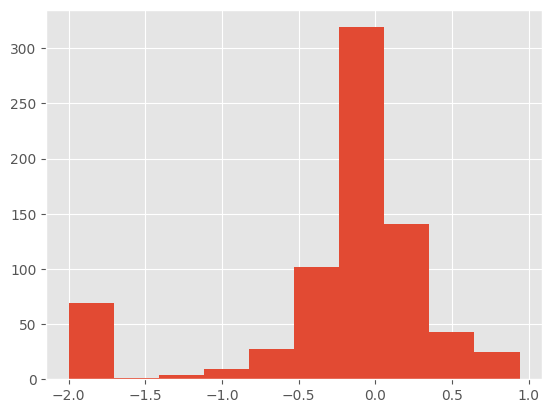

In [ ]:
df['fitness_fold_change'].hist()

In [ ]:
df['ID'] = 'POLG_HCVJF_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'fitness', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['fitness']).copy()
df.head()

,ID,mutant,fitness,mut_seqs
0,POLG_HCVJF_D1994C,D1994C,-1.0,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...
1,POLG_HCVJF_D1994D,D1994D,0.0,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...
2,POLG_HCVJF_D1994E,D1994E,-1.0,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...
3,POLG_HCVJF_D1994F,D1994F,-1.0,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...
4,POLG_HCVJF_D1994G,D1994G,-1.0,MSTNPKPQRKTKRNTNRRPEDVKFPGGGQIVGGVYLLPRRGPRLGV...


In [ ]:
# make fasta
fasta_file_maker(df, 'POLG_HCVJF_Sun2014')

In [ ]:
df.rename(columns={'fitness': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/POLG_HCVJF_Sun2014_metadata.csv')

# BRCA_HUMAN_RING

In [ ]:
# BRCA1_HUMAN_RING
idx = find_index("BRCA1_HUMAN_RING")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,function_score,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,A5T,-0.087838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,A5P,-0.892859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,A5S,-0.261441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,A5D,0.132687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,A5V,0.314080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
731,731,L99L,-0.222151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
732,732,E100D,-0.377926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
733,733,E100D,-0.377926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
734,734,Y101N,-0.674153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P38398.fasta', 'fasta').seq)
wt_seq

'MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKFCMLKLLNQKKGPSQCPLCKNDITKRSLQESTRFSQLVEELLKIICAFQLDTGLEYANSYNFAKKENNSPEHLKDEVSIIQSMGYRNRAKRLLQSEPENPSLQETSLSVQLSNLGTVRTLRTKQRIQPQKTSVYIELGSDSSEDTVNKATYCSVGDQELLQITPQGTRDEISLDSAKKAACEFSETDVTNTEHHQPSNNDLNTTEKRAAERHPEKYQGSSVSNLHVEPCGTNTHASSLQHENSSLLLTKDRMNVEKAEFCNKSKQPGLARSQHNRWAGSKETCNDRRTPSTEKKVDLNADPLCERKEWNKQKLPCSENPRDTEDVPWITLNSSIQKVNEWFSRSDELLGSDDSHDGESESNAKVADVLDVLNEVDEYSGSSEKIDLLASDPHEALICKSERVHSKSVESNIEDKIFGKTYRKKASLPNLSHVTENLIIGAFVTEPQIIQERPLTNKLKRKRRPTSGLHPEDFIKKADLAVQKTPEMINQGTNQTEQNGQVMNITNSGHENKTKGDSIQNEKNPNPIESLEKESAFKTKAEPISSSISNMELELNIHNSKAPKKNRLRRKSSTRHIHALELVVSRNLSPPNCTELQIDSCSSSEEIKKKKYNQMPVRHSRNLQLMEGKEPATGAKKSNKPNEQTSKRHDSDTFPELKLTNAPGSFTKCSNTSELKEFVNPSLPREEKEEKLETVKVSNNAEDPKDLMLSGERVLQTERSVESSSISLVPGTDYGTQESISLLEVSTLGKAKTEPNKCVSQCAAFENPKGLIHGCSKDNRNDTEGFKYPLGHEVNHSRETSIEMEESELDAQYLQNTFKVSKRQSFAPFSNPGNAEEECATFSAHSGSLKKQSPKVTFECEQKEENQGKNESNIKPVQTVNITAGFPVVGQKDKPVDNAKCSIKGGSRFCLSSQFRGNETGLITPNKHGLLQNPYRIPPLFPIKSFVKTKCKKNLL

In [ ]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,function_score,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,A5T,-0.087838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSTLRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
1,1,A5P,-0.892859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSPLRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
2,2,A5S,-0.261441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSSLRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
3,3,A5D,0.132687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSDLRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
4,4,A5V,0.314080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSVLRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
...,...,...,...,...,...,...,...,...,...,...,...,...
731,731,L99L,-0.222151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
732,732,E100D,-0.377926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
733,733,E100D,-0.377926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
734,734,Y101N,-0.674153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...


In [ ]:
df['ID'] = 'BRCA_RING_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'function_score', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['function_score']).copy()
df.head()

,ID,mutant,function_score,mut_seqs
0,BRCA_RING_A5T,A5T,-0.087838,MDLSTLRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
1,BRCA_RING_A5P,A5P,-0.892859,MDLSPLRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
2,BRCA_RING_A5S,A5S,-0.261441,MDLSSLRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
3,BRCA_RING_A5D,A5D,0.132687,MDLSDLRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
4,BRCA_RING_A5V,A5V,0.314080,MDLSVLRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...


In [ ]:
# make fasta
fasta_file_maker(df, 'BRCA1_HUMAN_RING')

In [ ]:
df.rename(columns={'function_score': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/BRCA1_HUMAN_RING_metadata.csv')

# BRCA_HUMAN_BRCT

In [ ]:
# BRCA1_HUMAN_BRCT
idx = find_index("BRCA1_HUMAN_BRCT")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,function_score,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,S1631G,0.305708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,S1631C,0.133622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,S1631N,-0.610019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,S1631T,-0.895748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,S1631I,-1.180832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1617,1617,I1855T,-0.291519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1618,1618,I1855R,-0.464328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1619,1619,I1855K,-0.863844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1620,1620,I1855M,0.021941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P38398.fasta', 'fasta').seq)
wt_seq

'MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKFCMLKLLNQKKGPSQCPLCKNDITKRSLQESTRFSQLVEELLKIICAFQLDTGLEYANSYNFAKKENNSPEHLKDEVSIIQSMGYRNRAKRLLQSEPENPSLQETSLSVQLSNLGTVRTLRTKQRIQPQKTSVYIELGSDSSEDTVNKATYCSVGDQELLQITPQGTRDEISLDSAKKAACEFSETDVTNTEHHQPSNNDLNTTEKRAAERHPEKYQGSSVSNLHVEPCGTNTHASSLQHENSSLLLTKDRMNVEKAEFCNKSKQPGLARSQHNRWAGSKETCNDRRTPSTEKKVDLNADPLCERKEWNKQKLPCSENPRDTEDVPWITLNSSIQKVNEWFSRSDELLGSDDSHDGESESNAKVADVLDVLNEVDEYSGSSEKIDLLASDPHEALICKSERVHSKSVESNIEDKIFGKTYRKKASLPNLSHVTENLIIGAFVTEPQIIQERPLTNKLKRKRRPTSGLHPEDFIKKADLAVQKTPEMINQGTNQTEQNGQVMNITNSGHENKTKGDSIQNEKNPNPIESLEKESAFKTKAEPISSSISNMELELNIHNSKAPKKNRLRRKSSTRHIHALELVVSRNLSPPNCTELQIDSCSSSEEIKKKKYNQMPVRHSRNLQLMEGKEPATGAKKSNKPNEQTSKRHDSDTFPELKLTNAPGSFTKCSNTSELKEFVNPSLPREEKEEKLETVKVSNNAEDPKDLMLSGERVLQTERSVESSSISLVPGTDYGTQESISLLEVSTLGKAKTEPNKCVSQCAAFENPKGLIHGCSKDNRNDTEGFKYPLGHEVNHSRETSIEMEESELDAQYLQNTFKVSKRQSFAPFSNPGNAEEECATFSAHSGSLKKQSPKVTFECEQKEENQGKNESNIKPVQTVNITAGFPVVGQKDKPVDNAKCSIKGGSRFCLSSQFRGNETGLITPNKHGLLQNPYRIPPLFPIKSFVKTKCKKNLL

In [ ]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,function_score,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,S1631G,0.305708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
1,1,S1631C,0.133622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
2,2,S1631N,-0.610019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
3,3,S1631T,-0.895748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
4,4,S1631I,-1.180832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
...,...,...,...,...,...,...,...,...,...,...,...,...
1617,1617,I1855T,-0.291519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
1618,1618,I1855R,-0.464328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
1619,1619,I1855K,-0.863844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
1620,1620,I1855M,0.021941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...


In [ ]:
df['ID'] = 'BRCA_BRCT_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'function_score', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['function_score']).copy()
df.head()

,ID,mutant,function_score,mut_seqs
0,BRCA_BRCT_S1631G,S1631G,0.305708,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
1,BRCA_BRCT_S1631C,S1631C,0.133622,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
2,BRCA_BRCT_S1631N,S1631N,-0.610019,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
3,BRCA_BRCT_S1631T,S1631T,-0.895748,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...
4,BRCA_BRCT_S1631I,S1631I,-1.180832,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...


In [ ]:
# make fasta
fasta_file_maker(df, 'BRCA1_HUMAN_BRCT')

In [ ]:
df.rename(columns={'function_score': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/BRCA1_HUMAN_BRCT_metadata.csv')

# UBE4B

In [ ]:
# UBE4B_MOUSE_Klevit2013-singles
idx = find_index("UBE4B_MOUSE_Klevit2013-singles")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,log2_ratio,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,I1072K,-0.095094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,I1072M,-0.123989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,I1072L,-0.608515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,I1072P,-2.485537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,I1072S,0.877033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
894,894,H1173Q,-0.298627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
895,895,H1173P,-0.061658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896,896,H1173S,-0.524198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
897,897,H1173R,-0.012880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/Q9ES00.fasta', 'fasta').seq)
wt_seq

'MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASAPGPSQSLGLNVHNMTPATSPIGAAGVAHRSQSSEGVSSLSSSPSNSLETQSQSLSRSQSMDIDGVSCEKSMSQVDVDSGIENMEVDENDRREKRSLSDKEPSSGPEVSEEQALQLVCKIFRVSWKDRDRDVIFLSSLSAQFKQNPKEVFSDFKDLIGQILMEVLMMSTQTRDENPFASLTATSQPIATAARSPDRNLMLNTGSSSGTSPMFCNMGSFSTSSLSSLGASGGASNWDSYSDHFTIETCKETDMLNYLIECFDRVGIEEKKAPKMCSQPAVSQLLSNIRSQCISHTALVLQGSLTQPRSLQQPSFLVPYMLCRNLPYGFIQELVRTTHQDEEVFKQIFIPILQGLALAAKECSLESDYFKYPLMALGELCETKFGKTHPMCNLVASLPLWLPKSLSPGSGRELQRLSYLGAFFSFSVFAEDDAKVVEKYFSGPAITLENTRVVSQSLQHYLELGRQELFKILHSILLNGETREAALSYMAALVNANMKKAQMQADDRLVSTDGFMLNLLWVLQQLSTKIKLETVDPTYIFHPRCRITLPNDETRINATMEDVNERLTELYGDQPPFSEPKFPTECFFLTLHAHHLSILPSCRRYIRRLRAIRELNRTVEDLKNNESQWKDSPLATRHREMLKRCKTQLKKLVRCKACADAGLLDESFLRRCLNFYGLLIQLMLRILDPAYPDVTLPLNSEVPKVFAALPEFYVEDVAEFLFFIVQYSPQVLYEPCTQDIVMFLVVMLCNQNYIRNPYLVAKLVEVMFMTNPSVQPRTQKFFEMIENHPLSTKLLVPSLMKFYTDVEHTGATSEFYDKFTIRYHISTIFKSLWQNIAHHGTFMEEFNSGKQFVRYINMLINDTTFLLDESLESLKRIHEVQEEMKNKEQWDQLPRDQQQARQSQLAQDERVSRSYLALATETVDMFHLLTKQVQKPFLRPELGPRLAAMLNFNLQQL

In [ ]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,log2_ratio,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,I1072K,-0.095094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...
1,1,I1072M,-0.123989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...
2,2,I1072L,-0.608515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...
3,3,I1072P,-2.485537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...
4,4,I1072S,0.877033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...
...,...,...,...,...,...,...,...,...,...,...,...,...
894,894,H1173Q,-0.298627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...
895,895,H1173P,-0.061658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...
896,896,H1173S,-0.524198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...
897,897,H1173R,-0.012880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...


In [ ]:
df['ID'] = 'UBE4B_' + df['mutant'].astype(str)
cols = ['ID', 'mutant', 'log2_ratio', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['log2_ratio']).copy()
df.head()

,ID,mutant,log2_ratio,mut_seqs
0,UBE4B_I1072K,I1072K,-0.095094,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...
1,UBE4B_I1072M,I1072M,-0.123989,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...
2,UBE4B_I1072L,I1072L,-0.608515,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...
3,UBE4B_I1072P,I1072P,-2.485537,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...
4,UBE4B_I1072S,I1072S,0.877033,MEELSADEIRRRRLARLAGGQTSQPTTPLTSPQRENPPGPPIAASA...


In [ ]:
# make fasta
fasta_file_maker(df, 'UBE4B_MOUSE_Klevit2013_singles')

In [ ]:
df.rename(columns={'log2_ratio': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/UBE4B_MOUSE_Klevit2013_singles_metadata.csv')

# HIS7_YEAST

In [ ]:
# HIS7_YEAST_Kondrashov2017
idx = find_index("HIS7_YEAST_Kondrashov2017")

df = pd.read_excel(xls, sheet_name=sheet_names[idx])
df

,Unnamed: 0,mutant,selection,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,0,S136C:N137D:V143I:E144N:I160V:P161T:F163V,0.755495,-15.943862,-17.530785,-17.612104,-15.884364,-13.445754,-15.246303,-18.254320,-8.702567
1,1,S136C:N137S:P139A:Y140F:A141S:V143I:E144D:I160...,0.475935,-15.698279,-16.372801,-16.491489,-16.287387,-15.433360,-13.906358,-22.597285,-11.727067
2,2,S136F:N137D:P139A:Y140F:V143I:E144N:I160V:F163V,0.000000,-24.192034,-24.507407,-26.717283,-23.230498,-24.479009,-22.025971,-26.449953,-16.924804
3,3,S136F:N137D:P139A:V142F:V143T:E144N:C157S:I160...,0.000000,-38.720357,-40.842497,-41.851209,-37.659202,-37.385112,-35.863763,-40.083288,-23.577922
4,4,S136F:N137D:P139A:A141C:E144D:I160V:F163I,0.000000,-25.134609,-25.532620,-27.530803,-24.140792,-25.502972,-22.965856,-26.213540,-17.060566
...,...,...,...,...,...,...,...,...,...,...,...
496132,496132,A6V:L7S:K9R:A20S:I21L:S22C:L23I,0.970580,-2.983466,-3.109168,-3.998026,-2.486703,-4.541689,-0.781747,-9.080205,-1.137491
496133,496133,A6V:L7S:K9R:I11N:S22G:K24N,0.893046,-0.359201,1.318447,-1.950515,1.534520,-3.082393,0.383937,-6.385503,1.129704
496134,496134,A6V:L7S:K9R:I11N:I19V:I21L,1.159665,2.423029,2.098580,2.214789,3.873660,0.303011,3.625106,-2.473602,2.668043
496135,496135,A6V:L7S:K9S:I11D:A20S:I21L:S22G:K24N,0.876360,2.445264,4.280428,0.571145,3.227030,0.206242,3.941473,-6.729412,3.015588


In [ ]:
wt_seq = str(SeqIO.read('data/DMS_wt_sequences/P06633.fasta', 'fasta').seq)
wt_seq

'MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQATQSQVINVHTGIGFLDHMIHALAKHSGWSLIVECIGDLHIDDHHTTEDCGIALGQAFKEALGAVRGVKRFGSGFAPLDEALSRAVVDLSNRPYAVVELGLQREKVGDLSCEMIPHFLESFAEASRITLHVDCLRGKNDHHRSESAFKALAVAIREATSPNGTNDVPSTKGVLM'

In [ ]:
df['mut_seqs'] = df['mutant'].apply(mutated_seqs, args=(wt_seq,))
df

,Unnamed: 0,mutant,selection,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,mut_seqs
0,0,S136C:N137D:V143I:E144N:I160V:P161T:F163V,0.755495,-15.943862,-17.530785,-17.612104,-15.884364,-13.445754,-15.246303,-18.254320,-8.702567,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
1,1,S136C:N137S:P139A:Y140F:A141S:V143I:E144D:I160...,0.475935,-15.698279,-16.372801,-16.491489,-16.287387,-15.433360,-13.906358,-22.597285,-11.727067,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
2,2,S136F:N137D:P139A:Y140F:V143I:E144N:I160V:F163V,0.000000,-24.192034,-24.507407,-26.717283,-23.230498,-24.479009,-22.025971,-26.449953,-16.924804,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
3,3,S136F:N137D:P139A:V142F:V143T:E144N:C157S:I160...,0.000000,-38.720357,-40.842497,-41.851209,-37.659202,-37.385112,-35.863763,-40.083288,-23.577922,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
4,4,S136F:N137D:P139A:A141C:E144D:I160V:F163I,0.000000,-25.134609,-25.532620,-27.530803,-24.140792,-25.502972,-22.965856,-26.213540,-17.060566,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
...,...,...,...,...,...,...,...,...,...,...,...,...
496132,496132,A6V:L7S:K9R:A20S:I21L:S22C:L23I,0.970580,-2.983466,-3.109168,-3.998026,-2.486703,-4.541689,-0.781747,-9.080205,-1.137491,MTEQKVSVRRITNETKIQISLCIKGGPLAIEHSIFPEKEAEAVAEQ...
496133,496133,A6V:L7S:K9R:I11N:S22G:K24N,0.893046,-0.359201,1.318447,-1.950515,1.534520,-3.082393,0.383937,-6.385503,1.129704,MTEQKVSVRRNTNETKIQIAIGLNGGPLAIEHSIFPEKEAEAVAEQ...
496134,496134,A6V:L7S:K9R:I11N:I19V:I21L,1.159665,2.423029,2.098580,2.214789,3.873660,0.303011,3.625106,-2.473602,2.668043,MTEQKVSVRRNTNETKIQVALSLKGGPLAIEHSIFPEKEAEAVAEQ...
496135,496135,A6V:L7S:K9S:I11D:A20S:I21L:S22G:K24N,0.876360,2.445264,4.280428,0.571145,3.227030,0.206242,3.941473,-6.729412,3.015588,MTEQKVSVSRDTNETKIQISLGLNGGPLAIEHSIFPEKEAEAVAEQ...


In [ ]:
#df['ID'] = 'HIS7_YEAST_' + df['mutant'].astype(str)
df['ID'] = ['HIS7_YEAST_' + str(i) for i in np.arange(1, len(df)+1)]
cols = ['ID', 'mutant', 'selection', 'mut_seqs']
df = df[cols]
df = df.dropna(subset=['selection']).copy()
df.head()

,ID,mutant,selection,mut_seqs
0,HIS7_YEAST_1,S136C:N137D:V143I:E144N:I160V:P161T:F163V,0.755495,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
1,HIS7_YEAST_2,S136C:N137S:P139A:Y140F:A141S:V143I:E144D:I160...,0.475935,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
2,HIS7_YEAST_3,S136F:N137D:P139A:Y140F:V143I:E144N:I160V:F163V,0.000000,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
3,HIS7_YEAST_4,S136F:N137D:P139A:V142F:V143T:E144N:C157S:I160...,0.000000,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...
4,HIS7_YEAST_5,S136F:N137D:P139A:A141C:E144D:I160V:F163I,0.000000,MTEQKALVKRITNETKIQIAISLKGGPLAIEHSIFPEKEAEAVAEQ...


In [ ]:
# make fasta
fasta_file_maker(df, 'HIS7_YEAST_Kondrashov2017')

In [ ]:
df.rename(columns={'selection': 'target', 'mut_seqs': 'sequence'}, inplace = True)
df.to_csv('data/metadata/HIS7_YEAST_Kondrashov2017_metadata.csv')

# Sequences sizes

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

In [ ]:
length = []
ds = []
for f in os.listdir('data/DMS_wt_sequences'):
    #print(f)
    if f.endswith(".fasta"):
        seq = SeqIO.read('data/DMS_DMS_wt_sequences/' + f, 'fasta').seq
        ds.append(f.split('.')[0])
        length.append(len(seq))
     
df = pd.DataFrame({'Dataset': ds, 'length': length}).sort_values('length', ascending=False)
df

,Dataset,length
16,Q99IB8,3033
2,BG505,2583
14,P38398,1863
6,Q9ES00,1173
32,P04386,881
12,BF520_ENV,852
15,P31016,724
26,PA_FLU,716
31,P02829,709
25,P04147,577


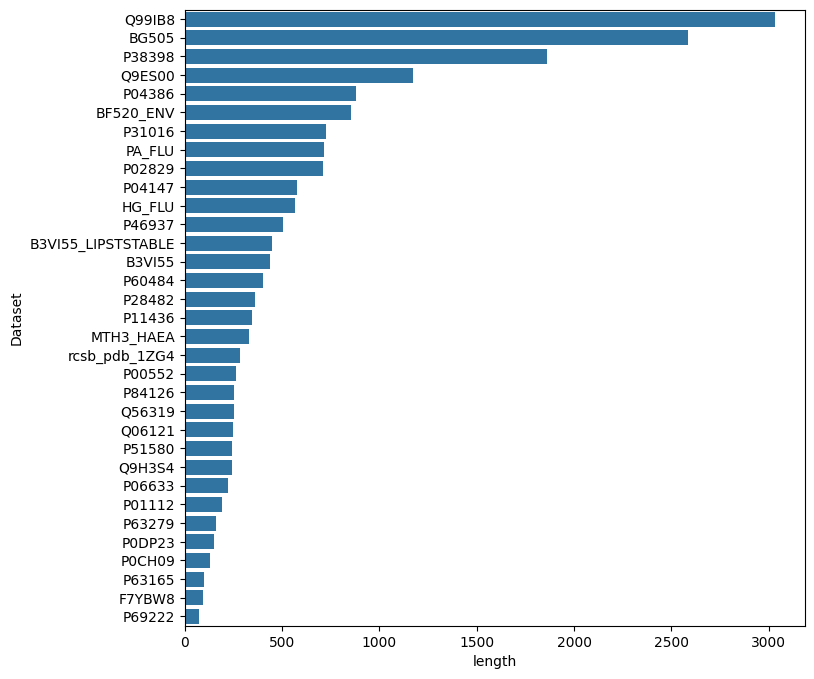

In [ ]:
plt.figure(figsize=(8, 8))
sns.barplot(y='Dataset', x='length', data=df)
plt.savefig('results/DMS_sequences_lengths.png', dpi=500, bbox_inches='tight')
plt.show()

## Dataset sample sizes

In [ ]:
dict_len = {}
dir = 'embeddings/DMS/'
for file in os.listdir(dir):
    if file.endswith('_esm2_150M'):
        file_name = file.split('_esm2_150M')[0]
        l = len(os.listdir(f'{dir}/{file}'))
        #dict_len[name_map[file_name]] = l
        dict_len[file_name] = l

df = pd.DataFrame.from_dict(dict_len, orient='index').sort_values(0, ascending=True).reset_index()
df.rename(columns={'index': 'Dataset', 0: 'length'}, inplace=True)
df

,Dataset,length
0,YAP1_HUMAN_Fields2012_singles,362
1,BRCA1_HUMAN_RING,660
2,UBE4B_MOUSE_Klevit2013_singles,899
3,BLAT_ECOLX_Tenaillon2013,989
4,PABP_YEAST_Fields2013_singles,1187
5,GAL4_YEAST_Shendure2015,1195
6,RL401_YEAST_Bolon2013,1269
7,RL401_YEAST_Fraser2016,1324
8,RL401_YEAST_Bolon2014,1435
9,IF1_ECOLI,1439


In [ ]:
# Define the bins and labels
bins = [0, 1000, 3200, 10000, 32000, float('inf')]
labels = ['<1000', '1000-3200', '3200-10000', '10000-32000',  '>320000']

# Create a new column with the binned data
df['binned_length'] = pd.cut(df['length'], bins=bins, labels=labels, right=False)
df


,Dataset,length,binned_length
0,YAP1_HUMAN_Fields2012_singles,362,<1000
1,BRCA1_HUMAN_RING,660,<1000
2,UBE4B_MOUSE_Klevit2013_singles,899,<1000
3,BLAT_ECOLX_Tenaillon2013,989,<1000
4,PABP_YEAST_Fields2013_singles,1187,1000-3200
5,GAL4_YEAST_Shendure2015,1195,1000-3200
6,RL401_YEAST_Bolon2013,1269,1000-3200
7,RL401_YEAST_Fraser2016,1324,1000-3200
8,RL401_YEAST_Bolon2014,1435,1000-3200
9,IF1_ECOLI,1439,1000-3200


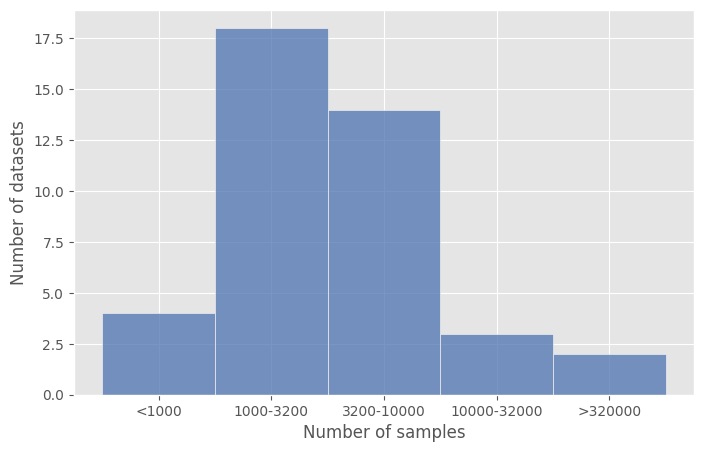

In [ ]:
# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='binned_length', color='#4c72b0')
plt.xlabel('Number of samples')
plt.ylabel('Number of datasets')
plt.savefig('results/DMS_sample_size.png', dpi=500, bbox_inches='tight')
plt.show()